# **IMPORTS**

In [1]:
%%time 

exec(open('/kaggle/usr/lib/playgrounds4e09_imports_v1/playgrounds4e09_imports_v1.py',
          'r'
         ).\
     read()
    )

%matplotlib inline

---> XGBoost = 2.0.3 | LightGBM = 4.5.0 | Catboost = 1.2.5
---> Sklearn = 1.2.2| Pandas = 2.2.2


---> Imports done

CPU times: user 4.02 s, sys: 502 ms, total: 4.52 s
Wall time: 9.98 s


# **INTRODUCTION**

## **CONFIGURATION**

In [2]:
%%time

# Configuration class:-
class CFG:
    """
    Configuration class for parameters and CV strategy for tuning and training
    Some parameters may be unused here as this is a general configuration class
    """;
    
    # Data preparation:-   
    version_nb         = 6
    
    # MAKE THIS AS N FOR ACTUAL RUN:-    
    test_req           = "N"
    test_sample_frac   = 0.01
    
    gpu_switch         = "OFF"
    state              = 42
    target             = "price"
    episode            = 9
    season             = 4
    path               = f"/kaggle/input/playground-series-s{season}e{episode}"
    orig_path1         = f"/kaggle/input/used-car-price-prediction-dataset/used_cars.csv"
    orig_path2         = f"/kaggle/input/kagglex-official-dataset/train.csv"
    
    dtl_preproc_req    = "Y"
    ftre_plots_req     = 'Y'
    ftre_imp_req       = "Y"
    
    # Data transforms and scaling:-    
    conjoin_orig_data  = "Y"
    nb_orig            = 1
    drop_nulls         = "N"
    sec_ftre_req       = "Y"
    scale_req          = "N"
    
    # Model Training:- 
    pstprcs_oof        = "N"
    pstprcs_train      = "N"
    pstprcs_test       = "N"
    ML                 = "Y"
    
    pseudo_lbl_req     = "N"
    pseudolbl_up       = 0.975
    pseudolbl_low      = 0.00
    
    n_splits           = 3 if test_req == "Y" else 5
    n_repeats          = 1 
    nbrnd_erly_stp     = 100
    mdlcv_mthd         = 'RKF'
    
    # Ensemble:-    
    ensemble_req       = "Y"
    hill_climb_req     = "N"
    optuna_req         = "Y"
    LAD_req            = "N"
    enscv_mthd         = "RKF"
    metric_obj         = 'minimize'
    ntrials            = 10 if test_req == "Y" else 200
    
    # Global variables for plotting:-
    grid_specs = {'visible': True, 'which': 'both', 'linestyle': '--', 
                           'color': 'lightgrey', 'linewidth': 0.75}
    title_specs = {'fontsize': 9, 'fontweight': 'bold', 'color': '#992600'}

print()
PrintColor(f"--> Configuration done!\n")
collect()


--> Configuration done!

CPU times: user 121 ms, sys: 923 µs, total: 122 ms
Wall time: 121 ms


4

## **CONFIGURATION PARAMETERS**


| Parameter         | Description                                             | Possible value choices|
| ---               | ---                                                     | :-:                   |
|  version_nb       | Version Number                                          | integer               |
|  test_req         | Are we testing syntax here?                             | Y/N                   |  
|  test_sample_frac | Sample size for syntax test                             | float(0-1)            |     
|  gpu_switch       | GPU switch                                              | ON/OFF                |
|  state            | Random state for most purposes                          | integer               |
|  targets          | Target column names                                     | list                  |
|  episode          | Episode Number                                          | integer               |
|  season           | Season Number                                           | integer               |    
|  path             | Path for input data files                               |                       |
|  orig_path        | Path for input original data files                      |                       |
|  dtl_preproc_req  | Proprocessing required                                  | Y/N                   |    
|  ftre_plots_req   | Feature plots required                                  | Y/N                   |
|  ftre_imp_req     | Feature importance required                             | Y/N                   |
|  conjoin_orig_data| Conjoin original data                                   | Y/N                   |
|  nb_orig          | Number of original data copies to append                | int                   |   
|  drop_nulls       | Drop original data nulls                                | Y/N                   |    
|  sec_ftre_req     | Secondary features required                             | Y/N                   |  
|  pstprcs_oof      | Post-process OOF after model training                   | Y/N                   |
|  pstprcs_train    | Post-process OOF during model training for dev-set      | Y/N                   |
|  pstprcs_test     | Post-process test after training                        | Y/N                   |
|  ML               | Machine Learning Models                                 | Y/N                   |
|  use_orig_all_folds| Use original data in all folds                         | Y/N                   |
|  n_splits         | Number of CV splits                                     | integer               |
|  n_repeats        | Number of CV repeats                                    | integer               |
|  nbrnd_erly_stp   | Number of early stopping rounds                         | integer               |
|  mdl_cv_mthd      | Model CV method name                                    | RKF/ RSKF/ SKF/ KFold |

## **UTILITIES**

In [3]:
%%time 

class Utils:
    """
    This class plots the final scores and generates adjutant model utilities
    """;
    
    def __init__(self, target):
        self.target = target;
        
    def DisplayAdjTbl(self, *args):
        """
        This function displays pandas tables in an adjacent manner, sourced from the below link-
        https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
        """;

        html_str = '';
        for df in args:
            html_str += df.to_html();
        display_html(html_str.replace('table','table style="display:inline"'),raw=True);
        collect();
    
    def DisplayScores(
        self, Scores: pd.DataFrame, TrainScores: pd.DataFrame, methods: list
    ):
        "This method displays the scores and their means";
               
        args = \
        [Scores.style.format(precision = 5).\
         background_gradient(cmap = "Blues", subset = methods + ["Ensemble"]).\
         set_caption(f"\nOOF scores across methods and folds\n"),

         TrainScores.style.format(precision = 5).\
         background_gradient(cmap = "Pastel2", subset = methods).\
         set_caption(f"\nTrain scores across methods and folds\n")
        ];

        PrintColor(f"\n\n\n---> OOF score across all methods and folds\n",
                   color = Fore.LIGHTMAGENTA_EX
                  );
        self.DisplayAdjTbl(*args);
        
        print('\n');
        display(Scores.mean().to_frame().\
                transpose().\
                style.format(precision = 5).\
                background_gradient(cmap = "mako", axis=1, subset = Scores.columns).\
                set_caption(f"\nOOF mean scores across methods and folds\n")
               );
 

utils = Utils(CFG.target);
collect();
print();


CPU times: user 123 ms, sys: 1.09 ms, total: 124 ms
Wall time: 123 ms


## **APPROACH DETAILS**
    
### **COLUMN DETAILS**<br>
This is available in the original data description as [here](https://www.kaggle.com/datasets/taeefnajib/used-car-price-prediction-dataset) <br>
Columns are as below- <br>
- Brand & Model: Identify the brand or company name along with the specific model of each vehicle.
- Model Year: Discover the manufacturing year of the vehicles, crucial for assessing depreciation and technology advancements.
- Mileage: Obtain the mileage of each vehicle, a key indicator of wear and tear and potential maintenance requirements.
- Fuel Type: Learn about the type of fuel the vehicles run on, whether it's gasoline, diesel, electric, or hybrid.
- Engine Type: Understand the engine specifications, shedding light on performance and efficiency.
- Transmission: Determine the transmission type, whether automatic, manual, or another variant.
- Exterior & Interior Colors: Explore the aesthetic aspects of the vehicles, including exterior and interior color options.
- Accident History: Discover whether a vehicle has a prior history of accidents or damage, crucial for informed decision-making.
- Clean Title: Evaluate the availability of a clean title, which can impact the vehicle's resale value and legal status.
- Price (target): Access the listed prices for each vehicle, aiding in price comparison and budgeting. <br>


### **COMPETITION DETAILS**
1. This is a regression challenge to predict the time taken to receive cancer treatment. **RMSE** is the metric for the challenge - **this needs to be minimized**<br>
2. In this starter notebook, we start the assignment with an autoML solution with moderate EDA. Let's explore the dataset and build better models going ahead!<br>
    
**Please make the parameter test_req = N for the actual run, currently this is executed for a small sample of train data as starters**

# **PREPROCESSING**

In [4]:
%time 

class Preprocessor():
    """
    This class aims to do the below-
    1. Read the datasets
    2. In this case, process the original data
    3. Check information and description
    4. Check unique values and nulls
    5. Collate starting features 
    6. Create the cross-validation folds as a column for all future runs
    """;
    
    def __init__(self):
        self.train             = pd.read_csv(os.path.join(CFG.path,"train.csv"), index_col = 'id')
        self.test              = pd.read_csv(os.path.join(CFG.path ,"test.csv"), index_col = 'id')
        self.target            = CFG.target 
        self.conjoin_orig_data = CFG.conjoin_orig_data
        self.dtl_preproc_req   = CFG.dtl_preproc_req
        self.test_req          = CFG.test_req
        
        self._CleanOrigDF()
        
        self.sub_fl = pd.read_csv(os.path.join(CFG.path, "sample_submission.csv"))
        PrintColor(f"Data shapes - train-test-original | {self.train.shape} {self.test.shape} {self.original.shape}")
        
        for tbl in [self.train, self.original, self.test]:
            obj_cols      = tbl.select_dtypes(include = ["object", "category"]).columns
            tbl.columns   = tbl.columns.str.replace(r"\(|\)|\.|\s+","", regex = True)
            
    def _CleanOrigDF(self):
        "This method makes and cleans the original dataset to make it compatible with the train data"
        
        self.original = pd.read_csv(CFG.orig_path1)
        self.original.index.name = "id"
        
        self.original.index = range(len(self.original))
        self.original.index.name = "id"
        
        self.original["milage"] = \
        self.original["milage"].str.replace(" mi.|,", "", regex = True).astype(np.uint32)
        
        self.original.index.name = "id"
        self.original[self.target] = \
        self.original[self.target].replace({'\$': '', ',': ''}, regex=True).\
        astype(np.uint32)
        
        self.original = \
        pd.concat(
            [self.original, 
             pd.read_csv(CFG.orig_path2)[self.original.columns]
            ],
            axis=0, ignore_index = True
        ).\
        drop("id", axis=1, errors = "ignore")
        
        self.original.columns = self.train.columns
     
    def _VisualizeDF(self):
        "This method visualizes the heads for the train, test and original data"
        
        PrintColor(f"\nTrain set head", color = Fore.CYAN)
        display(self.train.head(5).style.format(precision = 3))
        
        PrintColor(f"\nTest set head", color = Fore.CYAN)
        display(self.test.head(5).style.format(precision = 3))
        
        PrintColor(f"\nOriginal set head", color = Fore.CYAN)
        display(self.original.head(5).style.format(precision = 3))
              
    def _AddSourceCol(self):
        self.train['Source']    = "Competition";
        self.test['Source']     = "Competition";
        self.original['Source'] = 'Original';
        
        self.strt_ftre = self.test.columns;
        return self;
          
    def _CollateInfoDesc(self):
        if self.dtl_preproc_req == "Y":
            PrintColor(f"\n{'-' * 20} Information and description {'-' * 20}\n", color = Fore.MAGENTA);

            # Creating dataset information and description:
            for lbl, df in {'Train': self.train, 'Test': self.test, 'Original': self.original}.items():
                PrintColor(f"\n{lbl} description\n");
                display(df.describe(percentiles= [0.05, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).\
                        transpose().\
                        drop(columns = ['count'], errors = 'ignore').\
                        drop([self.target], axis=0, errors = 'ignore').\
                        style.format(formatter = '{:,.2f}').\
                        background_gradient(cmap = 'Blues')
                       );

                PrintColor(f"\n{lbl} information\n");
                display(df.info());
                collect();
        return self;
    
    def _CollateUnqNull(self):
        
        if self.dtl_preproc_req == "Y":
            # Dislaying the unique values across train-test-original:-
            PrintColor(f"\nUnique and null values\n")
            _ = pd.concat([self.train[self.strt_ftre].nunique(), 
                           self.test[self.strt_ftre].nunique(), 
                           self.original[self.strt_ftre].nunique(),
                           self.train[self.strt_ftre].isna().sum(axis=0),
                           self.test[self.strt_ftre].isna().sum(axis=0),
                           self.original[self.strt_ftre].isna().sum(axis=0)
                          ], 
                          axis=1)
            _.columns = ['Train_Nunq', 'Test_Nunq', 'Original_Nunq', 
                         'Train_Nulls', 'Test_Nulls', 'Original_Nulls'
                        ]
            display(_.T.style.background_gradient(cmap = 'Blues', axis=1).\
                    format(formatter = '{:,.0f}')
                   )
            
        return self;
    
    def _ConjoinTrainOrig(self):
        if self.conjoin_orig_data == "Y" :
            PrintColor(f"\n\nTrain shape before conjoining with original = {self.train.shape}")
            train = pd.concat([self.train, self.original], axis=0, ignore_index = True)
            PrintColor(f"Train shape after conjoining with original= {train.shape}")

            train = train.drop_duplicates();
            PrintColor(f"Train shape after de-duping = {train.shape}")

            train.index = range(len(train))
            train.index.name = 'id'

        else:
            PrintColor(f"\nWe are using the competition training data only")
            train = self.train
        return train
       
    def DoPreprocessing(self):
        self._VisualizeDF()
        self._AddSourceCol()
        self._CollateInfoDesc()
        self._CollateUnqNull()
        self.train = self._ConjoinTrainOrig()
        self.train.index = range(len(self.train))
        
        _ = self.train.drop(columns = [self.target, 'Source']).nunique()
        self.cat_cols  = _.loc[_ <= 25].index.to_list()
        self.cont_cols = [c for c in _.index if c not in self.cat_cols + ['Source']]
        return self; 
            
collect();
print();

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.63 µs



In [5]:
%%time 

pp = Preprocessor()
pp.DoPreprocessing()

print()
collect()

Data shapes - train-test-original | (188533, 12) (125690, 11) (58282, 12)

Train set head


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
id,,,,,,,,,,,,
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capability,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500



Test set head


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title
id,,,,,,,,,,,
188533,Land,Rover LR2 Base,2015,98000,Gasoline,240.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,6-Speed A/T,White,Beige,None reported,Yes
188534,Land,Rover Defender SE,2020,9142,Hybrid,395.0HP 3.0L Straight 6 Cylinder Engine Gasoline/Mild Electric Hybrid,8-Speed A/T,Silver,Black,None reported,Yes
188535,Ford,Expedition Limited,2022,28121,Gasoline,3.5L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,White,Ebony,None reported,nan
188536,Audi,A6 2.0T Sport,2016,61258,Gasoline,2.0 Liter TFSI,Automatic,Silician Yellow,Black,None reported,nan
188537,Audi,A6 2.0T Premium Plus,2018,59000,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,Gray,Black,None reported,Yes



Original set head


,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,51000,E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capability,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,10300
1,Hyundai,Palisade SEL,2021,34742,Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,38005
2,Lexus,RX 350 RX 350,2022,22372,Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,nan,54598
3,INFINITI,Q50 Hybrid Sport,2015,88900,Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric Hybrid,7-Speed A/T,Black,Black,None reported,Yes,15500
4,Audi,Q3 45 S line Premium Plus,2021,9835,Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,nan,34999



-------------------- Information and description --------------------


Train description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
model_year,"2,015.83",5.66,"1,974.00","2,004.00","2,013.00","2,017.00","2,020.00","2,022.00","2,022.00","2,023.00","2,024.00"
milage,"65,705.30","49,798.16",100.00,"4,200.00","24,115.00","57,785.00","95,400.00","136,731.00","161,800.00","201,509.00","405,000.00"



Train information

<class 'pandas.core.frame.DataFrame'>
Index: 188533 entries, 0 to 188532
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         188533 non-null  object
 1   model         188533 non-null  object
 2   model_year    188533 non-null  int64 
 3   milage        188533 non-null  int64 
 4   fuel_type     183450 non-null  object
 5   engine        188533 non-null  object
 6   transmission  188533 non-null  object
 7   ext_col       188533 non-null  object
 8   int_col       188533 non-null  object
 9   accident      186081 non-null  object
 10  clean_title   167114 non-null  object
 11  price         188533 non-null  int64 
 12  Source        188533 non-null  object
dtypes: int64(3), object(10)
memory usage: 20.1+ MB


None


Test description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
model_year,"2,015.80",5.67,"1,974.00","2,004.00","2,013.00","2,017.00","2,020.00","2,022.00","2,022.00","2,023.00","2,024.00"
milage,"66,042.58","50,223.86",100.00,"4,126.00","24,500.00","57,500.00","95,798.00","137,483.00","162,000.00","206,000.00","405,000.00"



Test information

<class 'pandas.core.frame.DataFrame'>
Index: 125690 entries, 188533 to 314222
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   brand         125690 non-null  object
 1   model         125690 non-null  object
 2   model_year    125690 non-null  int64 
 3   milage        125690 non-null  int64 
 4   fuel_type     122307 non-null  object
 5   engine        125690 non-null  object
 6   transmission  125690 non-null  object
 7   ext_col       125690 non-null  object
 8   int_col       125690 non-null  object
 9   accident      124058 non-null  object
 10  clean_title   111451 non-null  object
 11  Source        125690 non-null  object
dtypes: int64(2), object(10)
memory usage: 12.5+ MB


None


Original description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
model_year,"2,015.12",5.63,"1,974.00","2,004.00","2,012.00","2,016.00","2,019.00","2,021.00","2,022.00","2,023.00","2,024.00"
milage,"72,193.92","50,637.61",100.00,"5,700.00","31,350.00","65,000.00","101,750.00","141,800.00","167,500.00","217,500.00","405,000.00"



Original information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58282 entries, 0 to 58281
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   brand         58282 non-null  object
 1   model         58282 non-null  object
 2   model_year    58282 non-null  int64 
 3   milage        58282 non-null  int64 
 4   fuel_type     58112 non-null  object
 5   engine        58282 non-null  object
 6   transmission  58282 non-null  object
 7   ext_col       58282 non-null  object
 8   int_col       58282 non-null  object
 9   accident      58169 non-null  object
 10  clean_title   57686 non-null  object
 11  price         58282 non-null  int64 
 12  Source        58282 non-null  object
dtypes: int64(3), object(10)
memory usage: 5.8+ MB


None


Unique and null values



,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,Source
Train_Nunq,57,"1,897",34,"6,651",7,"1,117",52,319,156,2,1,1
Test_Nunq,55,"1,891",36,"5,700",7,"1,117",52,317,156,2,1,1
Original_Nunq,57,"1,898",34,"3,288",7,"1,146",62,319,156,2,1,1
Train_Nulls,0,0,0,0,"5,083",0,0,0,0,"2,452","21,419",0
Test_Nulls,0,0,0,0,"3,383",0,0,0,0,"1,632","14,239",0
Original_Nulls,0,0,0,0,170,0,0,0,0,113,596,0




Train shape before conjoining with original = (188533, 13)
Train shape after conjoining with original= (246815, 13)
Train shape after de-duping = (246815, 13)

CPU times: user 4.09 s, sys: 252 ms, total: 4.34 s
Wall time: 4.89 s


42

## **INFERENCES**

- We have to look into the nulls in the **clean_title, accident, fuel_type** columns <br>
- Exterior and interior colors have a lot of sub-categories, indicating hue and shades <br> 
- Even the model column has a lot of categories that could be binned with some level of text mining <br>

# **EDA**

In [6]:
%%time 

def MakeCrossTabs(target = CFG.target, train = pp.train):
    "This function makes cross-tabulations for EDA and data analysis"
    
    cols_dict = {"brand"          : "brand", 
                 "model year"     : "model_year",
                 "transmission"   : "transmission",
                 "accident"       : "accident",
                 "exterior color" : "ext_col",
                 "interior color" : "int_col", 
                }

    for label, col in cols_dict.items():
        print("\n\n")
        df = \
        train[[col, target]].groupby(col).\
        agg({target: ["max", "min", "mean", "median", "size"]})

        df.columns = ["max", "min", "mean", "median", "size"]
        props1 = "background-color: white; color: maroon; font-weight: bold; border: dashed black 1.4px"
        props2 = "background-color: white; color: blue; font-weight: bold; border: solid black 1.4px"
        
        
        display(df.sort_values(by = [col], ascending = True).\
                transpose().\
                style.format(formatter = '{:,.0f}').\
                set_caption(f"\nPrice details by {label}\n").\
                highlight_max(axis=1, props = props1).\
                highlight_min(axis=1, props = props2)              
               )
    
    print("\n\n\n")
    display(pp.train.\
            groupby(["Source"])[target].\
            describe(percentiles = np.arange(0.05, 0.96, 0.05)).\
            transpose().\
            style.format(formatter = '{:,.0f}').\
            highlight_max(axis=1, props = props1).\
            set_caption(f"Target distribution by data source")
           )


CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 13.4 µs


In [7]:
%%time 

MakeCrossTabs(target = CFG.target, train = pp.train)

brand,Acura,Alfa,Aston,Audi,BMW,Bentley,Bugatti,Buick,Cadillac,Chevrolet,Chrysler,Dodge,FIAT,Ferrari,Ford,GMC,Genesis,Honda,Hummer,Hyundai,INFINITI,Jaguar,Jeep,Karma,Kia,Lamborghini,Land,Lexus,Lincoln,Lotus,Lucid,MINI,Maserati,Maybach,Mazda,McLaren,Mercedes-Benz,Mercury,Mitsubishi,Nissan,Plymouth,Polestar,Pontiac,Porsche,RAM,Rivian,Rolls-Royce,Saab,Saturn,Scion,Subaru,Suzuki,Tesla,Toyota,Volkswagen,Volvo,smart
max,"2,954,083","649,999","2,954,083","2,954,083","1,950,995","2,954,083","1,950,995","449,991","2,954,083","2,954,083","2,954,083","2,954,083","359,991","1,599,000","2,954,083","2,954,083","1,599,000","2,954,083","2,954,083","2,954,083","2,954,083","695,000","1,950,995","64,500","749,950","1,950,995","2,954,083","2,954,083","491,836","96,500","279,950","243,900","2,954,083","90,200","1,950,995","599,000","2,954,083","429,998","1,950,995","1,599,000","100,000","108,900","2,954,083","2,954,083","2,954,083","695,000","1,950,995","75,500","200,000","119,900","489,995","101,999","2,954,083","2,954,083","599,995","489,000","84,997"
min,"2,000","3,000","3,850","2,000","2,000","2,300","67,900","2,800","2,000","2,000","2,300","2,000","4,700","3,990","2,000","2,000","2,900","2,000","2,300","2,000","2,000","2,000","2,000","18,387","2,000","3,000","2,000","2,000","2,000","2,300","9,499","2,000","2,300","15,500","2,000","7,950","2,000","3,000","2,000","2,000","3,850","12,000","2,000","2,000","2,500","5,900","4,995","2,900","2,300","2,900","2,300","6,499","5,500","2,000","2,000","2,000","5,000"
mean,"28,471","50,601","113,380","40,173","42,614","124,816","565,466","29,020","43,352","42,378","24,738","32,267","25,646","127,992","39,933","39,554","52,969","21,835","19,214","24,028","32,408","43,442","33,203","39,054","36,303","160,928","52,293","33,974","29,970","30,227","65,442","16,819","62,523","57,993","25,001","123,040","50,396","22,757","17,552","27,904","25,446","41,035","21,275","69,768","50,027","81,344","138,297","27,063","16,837","13,950","21,749","22,484","56,062","29,149","25,280","29,553","27,248"
median,"19,500","38,598","67,900","29,000","31,000","74,250","220,000","25,695","29,000","32,000","13,900","17,999","16,000","84,000","31,990","31,903","40,000","15,750","11,000","17,999","24,999","34,000","28,000","34,000","29,430","103,500","38,500","25,000","22,000","24,998","63,000","12,500","41,999","64,250","20,848","87,250","35,999","14,950","10,000","17,500","9,495","34,750","11,800","45,000","40,000","81,250","77,718","19,000","11,499","11,495","17,574","12,000","47,000","21,750","18,724","25,500","9,498"
size,"2,926",845,297,"14,009","24,772","1,472",9,"1,198","6,346","21,051","1,013","4,234",65,458,"30,180","4,382","1,238","2,788",712,"2,811","4,292","2,027","8,864",19,"3,099",957,"11,650","11,063","3,242",68,74,"1,461","1,266",7,"3,531",292,"24,574",80,753,"5,298",9,8,702,"13,440","5,306",634,714,24,211,179,"3,184",13,"3,935","11,364","2,452","1,213",4


model_year,1974,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
max,"197,499","94,000","488,880","2,954,083","1,599,000","220,000","599,995","349,950","96,900","349,950","2,954,083","2,954,083","2,954,083","2,954,083","2,954,083","2,954,083","2,954,083","2,954,083","1,950,995","2,954,083","1,950,995","1,950,995","1,950,995","2,954,083","2,954,083","1,950,995","2,954,083","2,954,083","2,954,083","2,954,083","2,954,083","2,954,083","2,954,083","425,000"
min,"9,999","3,950","2,500","2,000","2,000","2,000","2,000","2,500","2,000","2,000","2,000","2,000","2,000","2,000","2,000","2,000","2,000","2,000","2,300","2,000","2,000","2,000","2,000","2,300","2,300","2,800","2,899","2,899","2,990","2,900","2,899","2,899","3,499","7,858"
mean,"76,388","22,454","32,118","39,266","38,113","17,906","14,262","14,403","10,893","14,014","18,041","21,247","16,773","19,189","29,057","19,710","19,228","19,669","21,512","20,171","18,779","19,539","23,525","24,632","30,995","33,547","38,413","47,044","48,930","60,840","65,437","72,171","94,933","81,803"
median,"64,000","12,900","11,500","10,500","11,500","12,000","9,000","10,000","8,500","9,900","10,500","10,900","11,500","9,500","10,000","11,000","10,199","11,800","13,000","12,499","12,000","15,000","17,000","18,900","22,000","24,900","29,500","36,500","38,999","45,000","47,645","53,600","75,000","71,000"
size,18,27,196,136,156,273,401,471,745,727,"2,029","1,705","2,512","3,375","4,168","3,745","6,558","7,010","3,771","5,843","8,495","8,337","9,406","11,537","15,332","18,657","17,095","21,617","19,720","20,182","22,329","19,243","10,789",210


transmission,1-Speed A/T,1-Speed Automatic,10-Speed A/T,10-Speed Automatic,10-Speed Automatic with Overdrive,2,2-Speed A/T,2-Speed Automatic,4-Speed A/T,4-Speed Automatic,5-Speed A/T,5-Speed Automatic,5-Speed M/T,6 Speed At/Mt,6 Speed Mt,6-Speed,6-Speed A/T,6-Speed Automatic,6-Speed Automatic with Auto-Shift,6-Speed Electronically Controlled Automatic with O,6-Speed M/T,6-Speed Manual,7-Speed,7-Speed A/T,7-Speed Automatic,7-Speed Automatic with Auto-Shift,7-Speed DCT Automatic,7-Speed M/T,7-Speed Manual,8-SPEED A/T,8-SPEED AT,8-Speed A/T,8-Speed Automatic,8-Speed Automatic with Auto-Shift,8-Speed Manual,9-Speed A/T,9-Speed Automatic,9-Speed Automatic with Auto-Shift,A/T,"Auto, 6-Spd w/CmdShft",Automatic,Automatic CVT,"Automatic, 10-Spd","Automatic, 7-Spd S tronic Dual-Clutch","Automatic, 8-Spd","Automatic, 8-Spd Dual-Clutch","Automatic, 8-Spd M STEPTRONIC w/Drivelogic, Sport & Manual Modes","Automatic, 8-Spd PDK Dual-Clutch","Automatic, 8-Spd Sport w/Sport & Manual Modes","Automatic, 9-Spd 9G-Tronic",CVT Transmission,CVT-F,F,M/T,Manual,"Manual, 6-Spd",SCHEDULED FOR OR IN PRODUCTION,Single-Speed Fixed Gear,Transmission Overdrive Switch,Transmission w/Dual Shift Mode,Variable,–
max,"749,950","2,954,083","1,950,995","2,954,083","234,000","491,836","695,000","193,063","2,954,083","1,950,995","2,954,083","1,599,000","2,954,083","64,288","72,598","1,950,995","2,954,083","2,954,083","488,880","90,788","2,954,083","1,950,995","749,950","2,954,083","449,995","1,950,995","749,950","1,599,000","749,950","429,998","96,998","2,954,083","2,954,083","1,950,995","349,950","1,950,995","2,954,083","449,991","2,954,083","15,900","2,954,083","599,000","40,900","59,900","81,900","238,900","81,000","99,000","91,900","69,900","319,900","57,998","649,999","695,000","488,880","209,000","83,598","115,000","157,500","2,954,083","114,998","1,599,000"
min,"3,995","7,390","3,499","3,550","19,425","10,500","3,200","24,991","2,000","3,900","2,000","3,850","2,000","9,998","9,999","8,450","2,000","2,899","5,699","5,949","2,000","6,099","12,499","2,300","4,199","4,399","9,650","4,700","15,397","35,998","20,818","2,899","2,899","7,390","27,518","2,500","2,899","19,599","2,000","15,900","2,899","3,999","40,900","59,900","28,900","238,900","81,000","99,000","91,900","43,900","2,500","13,998","4,000","2,000","4,900","42,900","23,750","27,671","2,300","2,000","14,599","5,000"
mean,"57,549","68,594","59,190","63,229","69,159","51,968","67,100","78,693","19,355","81,663","20,171","51,374","16,034","34,952","36,106","105,866","25,633","38,781","48,931","32,427","33,512","117,965","203,798","47,240","61,340","129,165","121,308","83,160","149,883","196,104","44,976","55,353","67,541","152,225","109,724","57,857","63,159","111,357","31,278","15,900","59,590","37,492","40,900","59,900","59,650","238,900","81,000","99,000","91,900","56,900","25,406","31,826","45,340","27,025","108,871","125,950","49,171","75,541","26,256","49,230","46,889","168,321"
median,"48,000","45,998","49,000","44,999","68,229","37,334","62,000","69,995","9,999","25,182","13,000","32,115","11,500","36,353","38,348","39,985","19,995","29,998","28,196","28,374","22,000","55,655","175,000","32,500","42,599","68,750","67,250","63,500","116,911","190,225","41,298","40,000","41,927","104,500","84,632","44,900","40,528","80,500","19,999","15,900","44,998","30,890","40,900","59,900","63,900","238,900","81,000","99,000","91,900","56,900","21,000","27,785","33,748","16,000","43,775","125,950","53,998","78,350","23,000","35,470","42,598","98,446"
size,"1,993",385,"10,350","3,862",46,94,79,23,"3,382",60,"4,488",192,"3,186",22,40,31,"24,350","3,388",133,38,"15,864",253,37,"14,748",226,"1,306",25,469,175,8,14,"28,338","9,796",613,38,"5,013","2,716",36,"67,698",1,"11,369",961,1,1,4,1,1,1,1,2,"2,744",17,68,"1,578",29,2,9,17,217,"26,107",71,98


accident,At least 1 accident or damage reported,None reported
max,"2,954,083","2,954,083"
min,"2,000","2,000"
mean,"25,387","48,014"
median,"18,000","34,900"
size,"56,930","187,320"


ext_col,Agate Black Metallic,Alfa White,Alpine White,Alta White,Ametrin Metallic,Anodized Blue Metallic,Anthracite Blue Metallic,Antimatter Blue Metallic,Apex Blue,Arancio Borealis,Arctic Gray Metallic,Arctic White,Atomic Silver,Aurora Black,Aventurine Green Metallic,BLACK,BLU ELEOS,BLUE,Balloon White,Baltic Gray,Barcelona Red,Bayside Blue,Beige,Beluga Black,Bianco Icarus Metallic,Bianco Isis,Bianco Monocerus,Billet Clearcoat Metallic,Billet Silver Metallic Clearcoat,Black,Black Cherry,Black Clearcoat,Black Forest Green,Black Noir Pearl,Black Obsidian,Black Raven,Black Sapphire Metallic,Blu,Blue,Blue Caelum,Blue Metallic,Blue Reflex Mica,Blueprint,Brands Hatch Gray Metallic,Bright White Clearcoat,Brilliant Black,Brilliant Silver Metallic,Bronze Dune Metallic,Brown,Burnished Bronze Metallic,C / C,Cajun Red Tintcoat,Carbon Black Metallic,Carbonized Gray Metallic,Carpathian Grey,Carpathian Grey Premium Metallic,Carrara White Metallic,Caspian Blue,Caviar,Cayenne Red Tintcoat,Chalk,China Blue,Chronos Gray,Chronos Gray Metallic,Cirrus Silver Metallic,Cobra Beige Metallic,Crimson Red Tintcoat,Crystal Black,Crystal Black Pearl,Crystal Black Silica,Crystal White Pearl,Custom Color,DB Black Clearcoat,Dark Ash Metallic,Dark Graphite Metallic,Dark Gray Metallic,Dark Matter Metallic,Dark Moon Blue Metallic,Dark Moss,Dark Sapphire,Dark Slate Metallic,Daytona Gray,Daytona Gray Pearl Effect,Daytona Gray Pearl Effect w/ Black Roof,Dazzling White,Deep Black Pearl Effect,Deep Blue Metallic,Deep Crystal Blue Mica,Delmonico Red Pearlcoat,Designo Magno Matte,Diamond Black,Diamond White,Donington Grey Metallic,Ebony Black,Ebony Twilight Metallic,Eiger Grey,Eiger Grey Metallic,Electric Blue Metallic,Ember Pearlcoat,Emerald Green Metallic,Emin White,Eminent White Pearl,Firecracker Red Clearcoat,Firenze Red,Firenze Red Metallic,Flame Red Clearcoat,Florett Silver,Fountain Blue,Frozen Dark Silver Metallic,Frozen White,Fuji White,GT SILVER,Garnet Red Metallic,Gecko Pearlcoat,Gentian Blue Metallic,Glacial White Pearl,Glacier,Glacier Blue Metallic,Glacier Silver Metallic,Glacier White,Glacier White Metallic,Go Mango!,Gold,Granite,Granite Crystal Clearcoat Metallic,Granite Crystal Metallic Clearcoat,Graphite Grey,Graphite Grey Metallic,Gray,Green,Grigio Nimbus,Gun Metallic,Hampton Gray,Hellayella Clearcoat,Horizon Blue,Hydro Blue Pearlcoat,Hyper Red,Ibis White,Ice,Ice Silver Metallic,Iconic Silver Metallic,Imperial Blue Metallic,Indus Silver,Infrared Tintcoat,Ingot Silver Metallic,Iridescent Pearl Tricoat,Iridium Metallic,Iridium Silver Metallic,Ironman Silver,Isle of Man Green Metallic,Jet Black Mica,Jungle Green,Jupiter Red,Kemora Gray Metallic,Kinetic Blue,Kodiak Brown Metallic,Liquid Platinum,Lizard Green,Lunar Blue Metallic,Lunar Rock,Lunar Silver Metallic,Lunare White Metallic,MANUFAKTUR Diamond White Bright,Machine Gray Metallic,Magnetic Black,Magnetic Gray Clearcoat,Magnetic Gray Metallic,Magnetic Metallic,Magnetite Black Metallic,Magnetite Gray Metallic,Majestic Black Pearl,Majestic Plum Metallic,Mango Tango Pearlcoat,Manhattan Noir Metallic,Maroon,Matador Red Metallic,Matador Red Mica,Matte White,Maximum Steel Metallic,Metallic,Midnight Black,Midnight Black Metallic,Midnight Blue Metallic,Midnight Silver Metallic,Mineral White,Moonlight Cloud,Mosaic Black Metallic,Mountain Air Metallic,Mythos Black,Mythos Black Metallic,Nautical Blue Pearl,Navarra Blue,Navarra Blue Metallic,Navarre Blue,Nebula Gray Pearl,Nero Daytona,Nero Noctis,Nightfall Gray Metallic,Nightfall Mica,Northsky Blue Metallic,Obsidian,Obsidian Black Metallic,Octane Red Pearlcoat,Onyx,Onyx Black,Orange,Orca Black Metallic,Oryx White Prl,Oxford White,Pacific Blue,Pacific Blue Metallic,Passion Red,Patriot Blue Pearlcoat,Pearl White,Phantom Black,Phantom Black Pearl Effect / Black Roof,Phytonic Blue Metallic,Pink,Platinum Gray Metallic,Platinum Quartz Metallic,Platinum White Pearl,Polymetal Gray Metallic,Portofino Blue Metallic,Portofino Gray,Pristine White,Pure White,Purple,Python Green,

int_col,AMG Black,Adrenaline Red,Agave Green,Almond Beige,Amber,Anthracite,Aragon Brown,Ash,BEIGE,BLACK,Beige,Beluga,Beluga Hide,Bianco Polar,Black,Black / Brown,Black / Express Red,Black / Graphite,Black / Gray,Black / Saddle,Black / Stone Grey,Black Onyx,Black w/Red Stitching,Black/Graphite,Black/Gun Metal,Black/Red,Black/Saddle Brown,Blk,Blue,Boulder,Brandy,Brown,Camel,Camel Leather,Canberra Beige,Canberra Beige/Black,Cappuccino,Caramel,Carbon Black,Ceramic,Charcoal,Charcoal Black,Charles Blue,Chateau,Chestnut,Classic Red,Cloud,Cobalt Blue,Cocoa / Dune,Dark Ash,Dark Auburn,Dark Galvanized,Dark Gray,Deep Chestnut,Deep Cypress,Deep Garnet,Diesel Gray / Black,Ebony,Ebony / Ebony Accents,Ebony / Pimento,Ebony Black,Ebony.,Ebony/Light Oyster Stitch,Espresso,Giallo Taurus / Nero Ade,Gideon,Global Black,Gold,Grace White,Graphite,Graphite w/Gun Metal,Gray,Gray w/Blue Bolsters,Graystone,Green,Hotspur,Hotspur Hide,Ice,Ivory / Ebony,Jet Black,Kyalami Orange,Light Gray,Light Platinum / Jet Black,Light Slate,Light Titanium,Linen,Macchiato,Macchiato Beige/Black,Macchiato/Magmagrey,Magma Red,Medium Ash Gray,Medium Dark Slate,Medium Earth Gray,Medium Light Camel,Medium Pewter,Medium Stone,Mesa,Mistral Gray / Raven,Mocha,Mountain Brown,Navy Pier,Nero,Nero Ade,Nougat Brown,ORANGE,Obsidian Black,Orange,Orchid,Oyster W/Contrast,Oyster/Black,Parchment,Parchment.,Pearl Beige,Pimento / Ebony,Pimento Red w/Ebony,Platinum,Porpoise,Portland,Red,Red / Black,Red/Black,Rhapsody Blue,Rioja Red,Roast,Rock Gray,Saddle Brown,Sahara Tan,Saiga Beige,Sakhir Orange,Sakhir Orange/Black,Sand Beige,Sandstone,Sarder Brown,Satin Black,Shale,Shara Beige,Silk Beige/Black,Silk Beige/Espresso Brown,Silver,Slate,Sport,Tan,Tan/Ebony,Tan/Ebony/Ebony,Tension,Titan Black,Titan Black / Quarzit,Tupelo,Very Light Cashmere,WHITE,Walnut,Whisper Beige,White,White / Brown,Yellow,–
max,"425,000","1,599,000","449,991","279,950","599,000","172,900","179,900","59,203","96,900","749,950","2,954,083","488,880","1,599,000","359,991","2,954,083","1,950,995","1,950,995","79,998","239,995","288,900","179,900","749,950","254,900","243,900","259,000","171,900","429,998","267,950","1,950,995","96,850","1,950,995","2,954,083","149,900","2,954,083","162,950","217,950","179,900","109,499","64,250","83,900","279,950","359,991","695,000","76,598","749,950","359,991","239,991","599,995","209,900","179,900","2,954,083","162,950","197,499","76,500","289,991","489,995","2,954,083","2,954,083","185,950","238,900","449,991","267,950","199,991","279,900","449,995","69,790","449,991","2,954,083","449,995","599,995","359,991","2,954,083","117,900","479,995","1,599,000","1,950,995","749,950","359,991","106,798","2,954,083","359,991","42,816","77,900","479,995","274,900","2,954,083","349,950","226,000","429,998","749,950","54,543","2,954,083","2,954,083","324,995","82,950","489,995","695,000","132,900","749,950","62,999","239,991","749,950","1,950,995","229,900","96,998","279,950","1,599,000","599,995","107,900","106,798","359,991","489,995","267,950","199,998","117,900","62,890","289,991","1,950,995","2,954,083","272,950","479,995","193,063","749,950","199,991","229,900","359,991","491,836","162,950","244,896","209,991","84,645","2,954,083","238,900","491,836","1,950,995","2,954,083","142,998","274,900","489,000","134,900","289,991","695,000","143,998","193,063","259,991","209,995","349,950","56,740","128,995","209,000","489,995","59,598","2,954,083","193,063","1,599,000","1,950,995"
min,"20,399","21,373","28,895","22,495","17,899","16,998","18,688","13,046","14,999","27,499","2,000","13,850","21,612","41,400","2,000","17,816","9,985","12,749","13,046","13,895","4,999","2,899","10,998","12,900","11,500","31,698","17,800","5,000","2,000","6,880","16,770","2,000","19,000","15,499","5,230","9,599","19,599","8,450","17,999","13,310","3,850","7,390","13,998","15,995","18,795","29,497","14,798","17,816","19,212","12,995","24,900","19,290","5,899","10,795","6,699","6,099","3,499","3,499","5,949","13,046","9,450","8

Source,Competition,Original
count,"188,533","58,282"
mean,"43,878","39,585"
std,"78,820","73,258"
min,"2,000","2,000"
5%,"6,999","6,500"
10%,"9,900","9,000"
15%,"12,000","11,495"
20%,"14,999","13,500"
25%,"17,000","15,900"
30%,"19,500","17,900"


CPU times: user 739 ms, sys: 6.19 ms, total: 745 ms
Wall time: 740 ms


In [8]:
%%time 

def PlotTarget(train: pd.DataFrame = pp.train, target: str = CFG.target):
    "This function plots the target across the train and original datasets"
    
    fig, axes = plt.subplots(1,3, 
                             figsize = (16, 5),
                             gridspec_kw = {"hspace": 0.3, "wspace": 0.25,
                                            "width_ratios": [0.7, 0.2, 0.2]
                                           }
                            )


    ax = axes[0]
    sns.kdeplot(
        data = train[[target, "Source"]],
        hue = "Source",
        x = target,
        palette = ["tab:blue", "red"],
        log_scale = True,
        ax = ax,
    )
    ax.set_title(f"\nTarget density plots by data source\n", 
                 y = 0.99, 
                 **CFG.title_specs
                )
    ax.set_yticks(np.arange(0, 0.96, 0.05), 
                  labels = np.around(np.arange(0, 0.96, 0.05), 3),
                  fontsize = 7, 
                 )
    ax.set(ylabel = "")

    ax = axes[1]
    sns.boxplot(
        y = train.loc[train.Source == "Competition", target], 
        palette = ["#0000e6"],
        ax = ax,
    )
    ax.set_title(f"\nTarget box plot- train\n", y = 0.99, **CFG.title_specs)
    ax.set(ylabel = "")
    ax.set_yscale("log", base = 10)

    ax = axes[2]
    sns.boxplot(
        y = train.loc[train.Source == "Original", target], 
        palette = ["#1a75ff"],
        ax = ax,
    )
    ax.set_title(f"\nTarget box plot- original\n", y = 0.99, **CFG.title_specs)
    ax.set(ylabel = "")
    ax.set_yscale("log", base = 10)

    plt.tight_layout()
    plt.show()
    

    

CPU times: user 12 µs, sys: 0 ns, total: 12 µs
Wall time: 16.7 µs


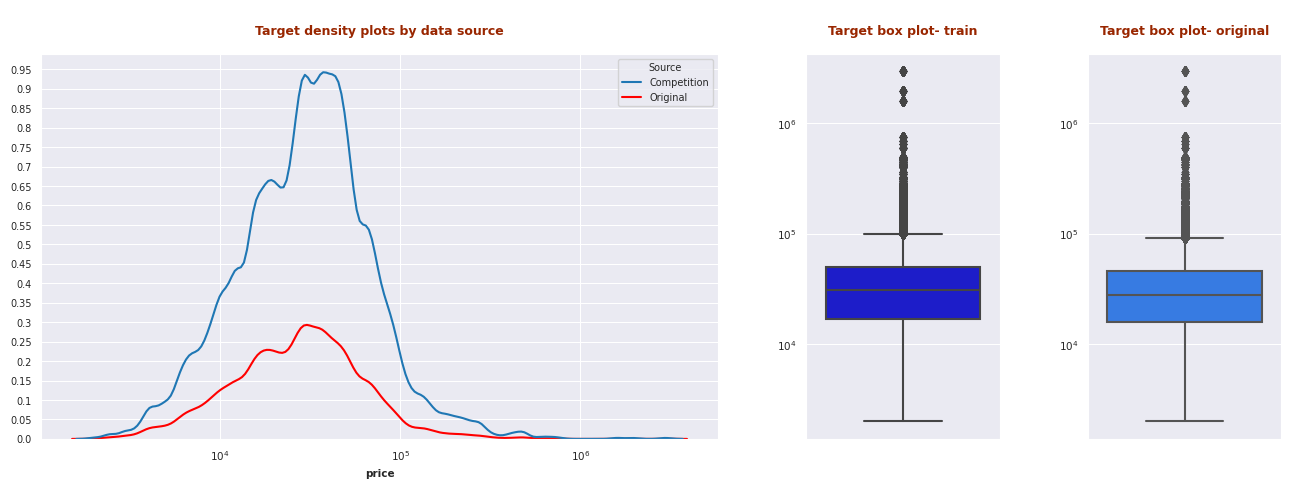

CPU times: user 3.84 s, sys: 465 ms, total: 4.3 s
Wall time: 3.2 s


In [9]:
%%time 

if CFG.ftre_plots_req == "Y":
    PlotTarget()

In [10]:
%%time 

obj_cols = pp.train.select_dtypes(include = ["object", "category"]).columns[0:-1]

# Testing for test-data unique categories:-
unq_vals = {}
for col in obj_cols:
    unq_vals[col] =  set(pp.test[col].unique()).difference(set(pp.train[col].unique()))
  
PrintColor(f"\nUnique values in test compared to train data\n")
pprint(unq_vals, width = 100, indent = 5, depth = 2)

# Testing for train-data unique categories:-
print("\n\n\n")
unq_vals = {}
for col in obj_cols:
    unq_vals[col] =  set(pp.train[col].unique()).difference(set(pp.test[col].unique()))
    
PrintColor(f"\nUnique values in train compared to test data\n") 
pprint(unq_vals, width = 100, indent = 5, depth = 2)

print()
collect();


Unique values in test compared to train data

{    'accident': set(),
     'brand': set(),
     'clean_title': set(),
     'engine': set(),
     'ext_col': set(),
     'fuel_type': set(),
     'int_col': set(),
     'model': set(),
     'transmission': set()}





Unique values in train compared to test data

{    'accident': set(),
     'brand': {'Polestar', 'smart'},
     'clean_title': set(),
     'engine': {    '1.6L I-4 gasoline direct injection, DOHC, variable valve control',
                    '2.5L I-4 DOHC, variable valve control, regular unleaded, engine',
                    '2.9L V-6 gasoline direct injection, DOHC, variable valve control',
                    '2L H-4 DOHC, variable valve control, regular unleaded, engine wi',
                    '2L H-4 gasoline direct injection, DOHC, variable valve control,',
                    '2L I-4 DOHC, D-CVVT variable valve control, engine with 147HP',
                    '2L I-4 gasoline direct injection, DOHC, intercooled turb

## **INFERENCES**

In [11]:
class DataAnalyzer:
    def __init__(self, n_head: int = 25):
        self.n_head = n_head
    
    def DisplayAdjTbl(self, *args):
        """
        This function displays pandas tables in an adjacent manner, sourced from the below link-
        https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
        """;

        html_str = ''
        for df in args:
            html_str += df.to_html()
        display_html(html_str.replace('table','table style="display:inline"'),raw=True)
        collect()
        
    def MakeGroupedDF(self):
        "This method creates the base dataset for the analysis"
    
        self.df = \
        pp.train[["brand", "transmission", CFG.target]].\
        groupby(["brand", "transmission"]).\
        agg({CFG.target : ["size", "mean", "median", "min", "max"]})

        self.df.columns = ["size", "mean", "median", "min", "max"]
        
    def Visualize(self):
        "This method visualizes the dataset side-by-side"
        
        self.MakeGroupedDF()
        
        args   = []
        for col in ["mean", "size", "min", "max"]:
            args.append(self.df.sort_values(by = [col], ascending = [False]).head(self.n_head)[["size", col]].\
                        style.\
                        set_caption(f"Top {self.n_head} car types by {col}- brand and transmision").\
                        format(formatter = '{:,.0f}')
                       )   
        self.DisplayAdjTbl(*args)     

In [12]:
%%time 

print("\n\n\n")
da = DataAnalyzer(25)
da.Visualize()

,,size,mean
brand,transmission,,
Cadillac,4-Speed Automatic,1,"1,950,995"
Bugatti,7-Speed Automatic with Auto-Shift,4,"1,066,848"
Lamborghini,5-Speed Automatic,4,"511,500"
Alfa,1-Speed Automatic,1,"489,995"
McLaren,9-Speed Automatic,1,"469,900"
Rolls-Royce,–,8,"451,004"
Cadillac,8-Speed Automatic with Auto-Shift,1,"449,995"
Audi,7-Speed DCT Automatic,3,"335,983"
Mercedes-Benz,–,2,"335,500"


CPU times: user 263 ms, sys: 1.17 ms, total: 264 ms
Wall time: 262 ms


## **INFERENCES**

### **BRAND ANALYSIS** <br>
- This dataset contains a lot of car brands across economic bands. We have a few vintage cars, luxury cars, daily usage cars and low-end car brands, all in the same dataset <br>
- Luxury brands like **Bugatti and Bentley** dominate for mean and median price and are upper-end outliers in pricing. Lower end brands like **Scion and Smart** have a low mean price <br>
- Luxury brands have a very high max-price compared to average and lower end brands, the figure **2954083** dominates as the maximum price. Similar, several car brands host models in the minimum level of **2000** also <br>
- **Ford** has the maximum number of cars in the dataset, **Smart and Meybach** have the minimum number of cars <br>

### **COLOR ANALYSIS** <br>
- **Black cars** are most common and **mango tango pearlcoat** cars are least common by external color <br> 
- **Black cars** are most common and **cobalt blue** cars are least common by internal color <br> 
- Mean-median prices of blue shades like **blue caelum** and **blu eleos** are high and worth noting for external color <br>
- Mean-median prices of **gold** are low and worth noting for external color<br>
- Mean-median prices of blue shades like **blue cobalt** are high and worth noting for internal color <br>
- Mean-median prices of grey shades like **gray and light gray** are low and worth noting for internal color<br>

### **TRANSMISSION ANALYSIS** <br>
- Simple automatic transmission dominates in terms of counts in the dataset <br> 
- Exotic transmission types of luxury cars like **automatic, 8-spd dual-clutch** have highest mean-median prices <br>
- Manual transmission and transmission w/dual shift mode cars have the lowest mean prices <br> 

### **OTHERS** <br>
- Most common year of manufacturing is **2021** and vintage cars in **1974** are highly rare <br>
- Cars with accident history are obviously sold at lower price <br> 
- Target distribution across competition train and original datasets is almost the same, but original data percentiles show a slightly lower value for most bins <br>
- Brands like **Smart and Polestar** are not present in the test data. Are we better suited to purging them in the model process? <br>
- Do we have an upper limit on the max-price and a lower limit on the min-prices? <br>

### **KEY NOTES** <br>
- **Do we need so many categories across automatic and manual transmission types?** <br>
- Text columns like engine-type, transmission and color categories perhaps necessitate further review and work <br>

In [13]:
%%time 

class BrandPosAnalyzer:
    "This class makes a 4-quadrant plot of brands for prices and sales volumes"
    
    def __init__(self, need_legend: bool = False):
        self.need_legend = need_legend
    
    def MakeBaseData(self):
        "This method makes the data for the plot"
        
        df = \
        pp.train[["brand", CFG.target]].\
        groupby("brand").\
        agg(volume       = pd.NamedAgg(CFG.target, "size"),
            mean_price   = pd.NamedAgg(CFG.target, "mean"), 
           )

        df["mean_price"] = np.log1p(df["mean_price"])
        df["volume"]     = np.log1p(df["volume"])

        mean_pr  = df["mean_price"].mean()
        mean_vol = df["volume"].mean()
        
        return df, mean_pr, mean_vol
        
    def MakeSnsPlot(self):
        "This method makes a seaborn plot for the 4-quadrant analysis"
        
        df, mean_pr, mean_vol = self.MakeBaseData()
        
        fig, ax = plt.subplots(1,1, figsize = (30, 15))
        sns.scatterplot(data = df, 
                        x = 'mean_price', y = 'volume', 
                        hue='brand', 
                        s = 100, 
                        palette = "icefire", 
                        ax = ax
                       )

        ax.axhline(y = mean_vol, color = 'blue', linestyle='--', linewidth = 1.5)
        ax.axvline(x = mean_pr, color  = 'blue', linestyle='--', linewidth = 1.5)

        for i in range(df.shape[0]):
            ax.text(df['mean_price'][i], 
                    df['volume'][i], 
                    df.index[i], 
                    fontsize = 8, 
                    ha='right', 
                   )
            
        for spine in ax.spines.values():
            spine.set_visible(True)
            spine.set_color("black")
            
        ax.set_facecolor('white')   
        if self.need_legend:
            ax.legend(title = 'Brand', 
                      bbox_to_anchor = (1.1, 1), 
                      loc = 'upper right', 
                      fontsize = "large"
                     )
        else:
            ax.get_legend().remove()
            
        _ = ax.set_yticks(np.arange(0, 11, 0.25), 
                          labels = np.around(np.arange(0, 11, 0.25), 3), 
                          fontsize = 8
                         )
        ax.set_title(f"\nBrand positioning analysis by price-sales volumes\n", **CFG.title_specs)

        plt.tight_layout()
        plt.show()
        
    def MakePlotlyPlot(self):
        
        df, mean_pr, mean_vol = self.MakeBaseData()
        
        fig = px.scatter(df, 
                         x = 'mean_price', 
                         y = 'volume', 
                         text  = df.index.astype(str), 
                         color = df.index.astype(str),
                         labels= {'mean_price': 'Price', 'volume': 'Volume'},
                         title = f"\nBrand positioning analysis by price-sales volumes\n"
                        )

        fig.add_shape(type = 'line', 
                      x0 = mean_pr, y0 = df['volume'].min(), 
                      x1 = mean_pr, y1 = df['volume'].max(),
                      line = dict(color='Black', dash='dash')
                     )
        fig.add_shape(type='line', 
                      x0 = df['mean_price'].min(), y0 = mean_vol, 
                      x1 = df['mean_price'].max(), y1 = mean_vol,
                      line = dict(color='Black', dash='dash')
                     )

        fig.update_layout(
            title_x = 0.5,
            xaxis_title ='Price',
            yaxis_title='Volume',
            showlegend = False,
            width  = 1300,  
            height = 800,  
        )

        fig.update_traces(textposition = 'top right', marker=dict(size=5))
        fig.update_layout(title_x = 0.5, xaxis_title='Price', yaxis_title= 'Volume',
                          showlegend = False
                         )
        fig.show()
        

CPU times: user 33 µs, sys: 0 ns, total: 33 µs
Wall time: 37.4 µs


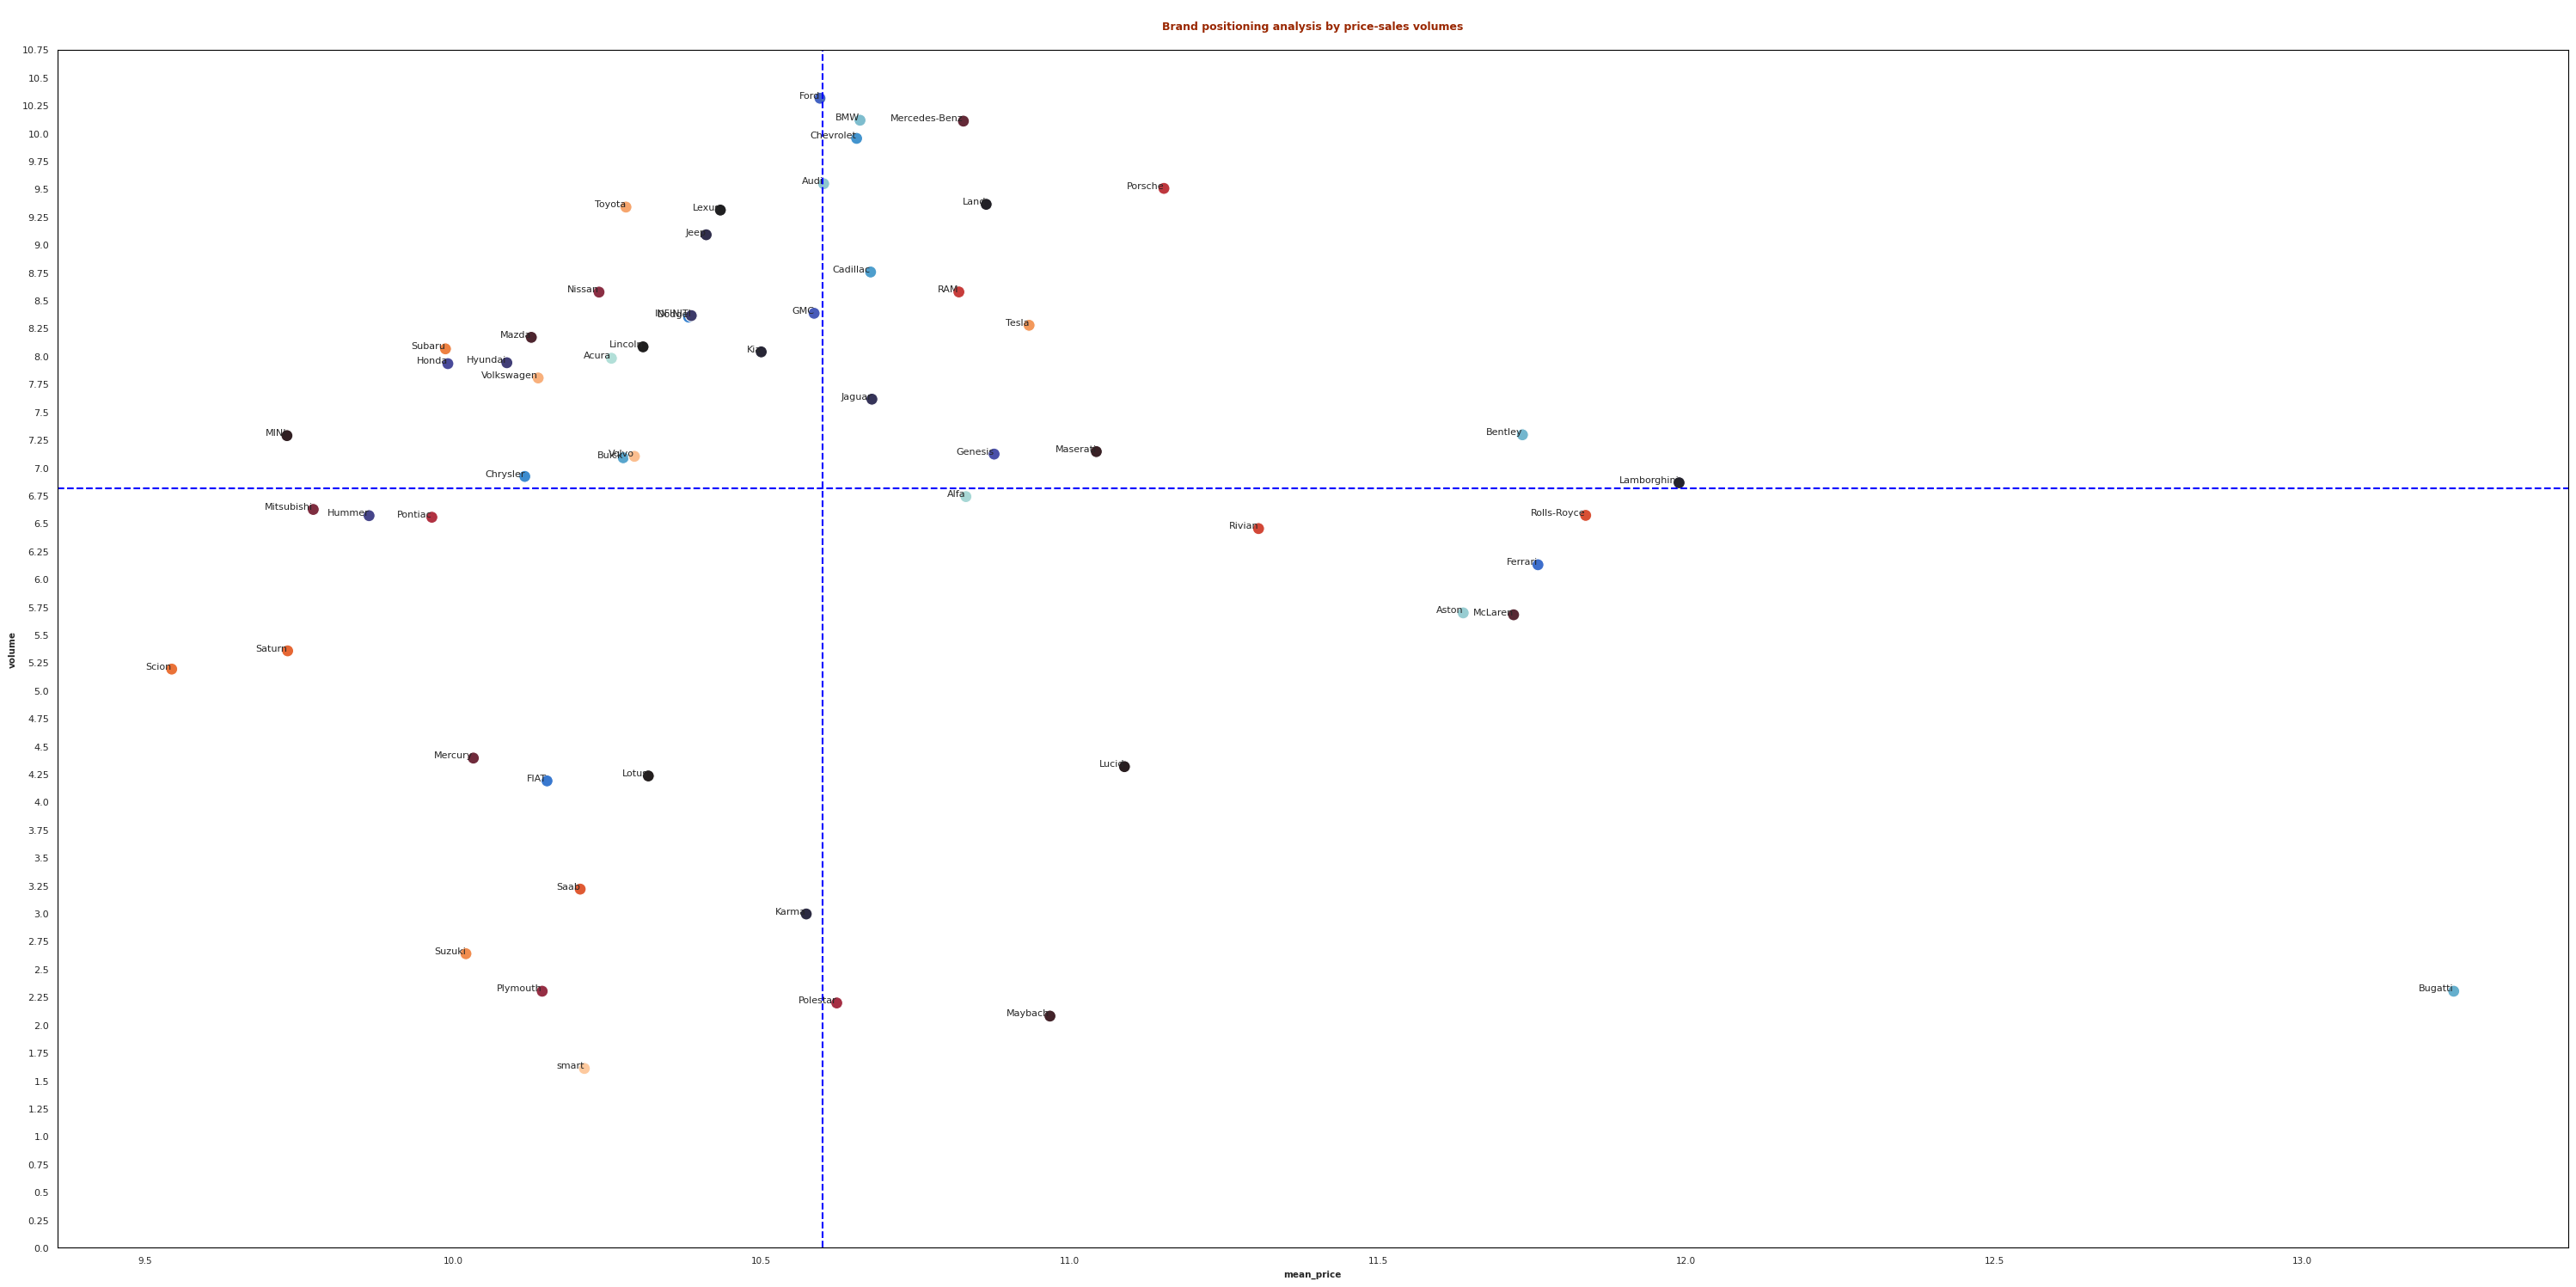

CPU times: user 2.33 s, sys: 457 ms, total: 2.79 s
Wall time: 2.07 s


In [14]:
%%time 

if CFG.ftre_plots_req == "Y":
    quad_plot = BrandPosAnalyzer()
    quad_plot.MakeSnsPlot()

In [15]:
%%time 

if CFG.ftre_plots_req == "Y":
    quad_plot.MakePlotlyPlot()

CPU times: user 1.57 s, sys: 257 ms, total: 1.83 s
Wall time: 2.5 s


## **INFERENCES**

The figure above clearly indicates the heterogenity in the brands present in the data. <br>
- Brands like Bugatti and Maybach have low volume and high prices while others like Suzuki and Saturn have low prices and higher sales volume. <br>
- Aspirational brands like Mercedes, Cadillac, Ram and Tesla are worthy of further exploration (moderate volume and high enough prices) <br>
- Daily usage brands like Honda, Nissan and mazda are placed in lower prices and higher volumes <br>
- Brand placement of **Ford** is highly interesting

In [16]:
%%time 

def AnalyzeMilage(train: pd.DataFrame, label: str):
    """
    This function analyses the milage attribute
    It plots the correlation for training data, train+original data and original data as well
    """
    
    fig, ax = plt.subplots(1,1, figsize = (20, 8))
    ovr_corr = np.corrcoef(train["milage"], train[CFG.target])[0,1]

    train[["milage", "brand", CFG.target]].\
    groupby("brand").\
    apply(lambda x: np.corrcoef(x["milage"], x[CFG.target])[0,1]).\
    plot.bar(color = "tab:blue", ax = ax)

    ax.set_facecolor('white')
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color("black")

    ax.axhline(y = ovr_corr , linewidth = 1.25, color = "maroon", linestyle = "dashed")
    ax.set_title(f"\nMilage versus target {label} -- correlation = {ovr_corr :.4f} \n", 
                 **CFG.title_specs)

    plt.tight_layout()
    plt.show()

CPU times: user 9 µs, sys: 0 ns, total: 9 µs
Wall time: 13.1 µs


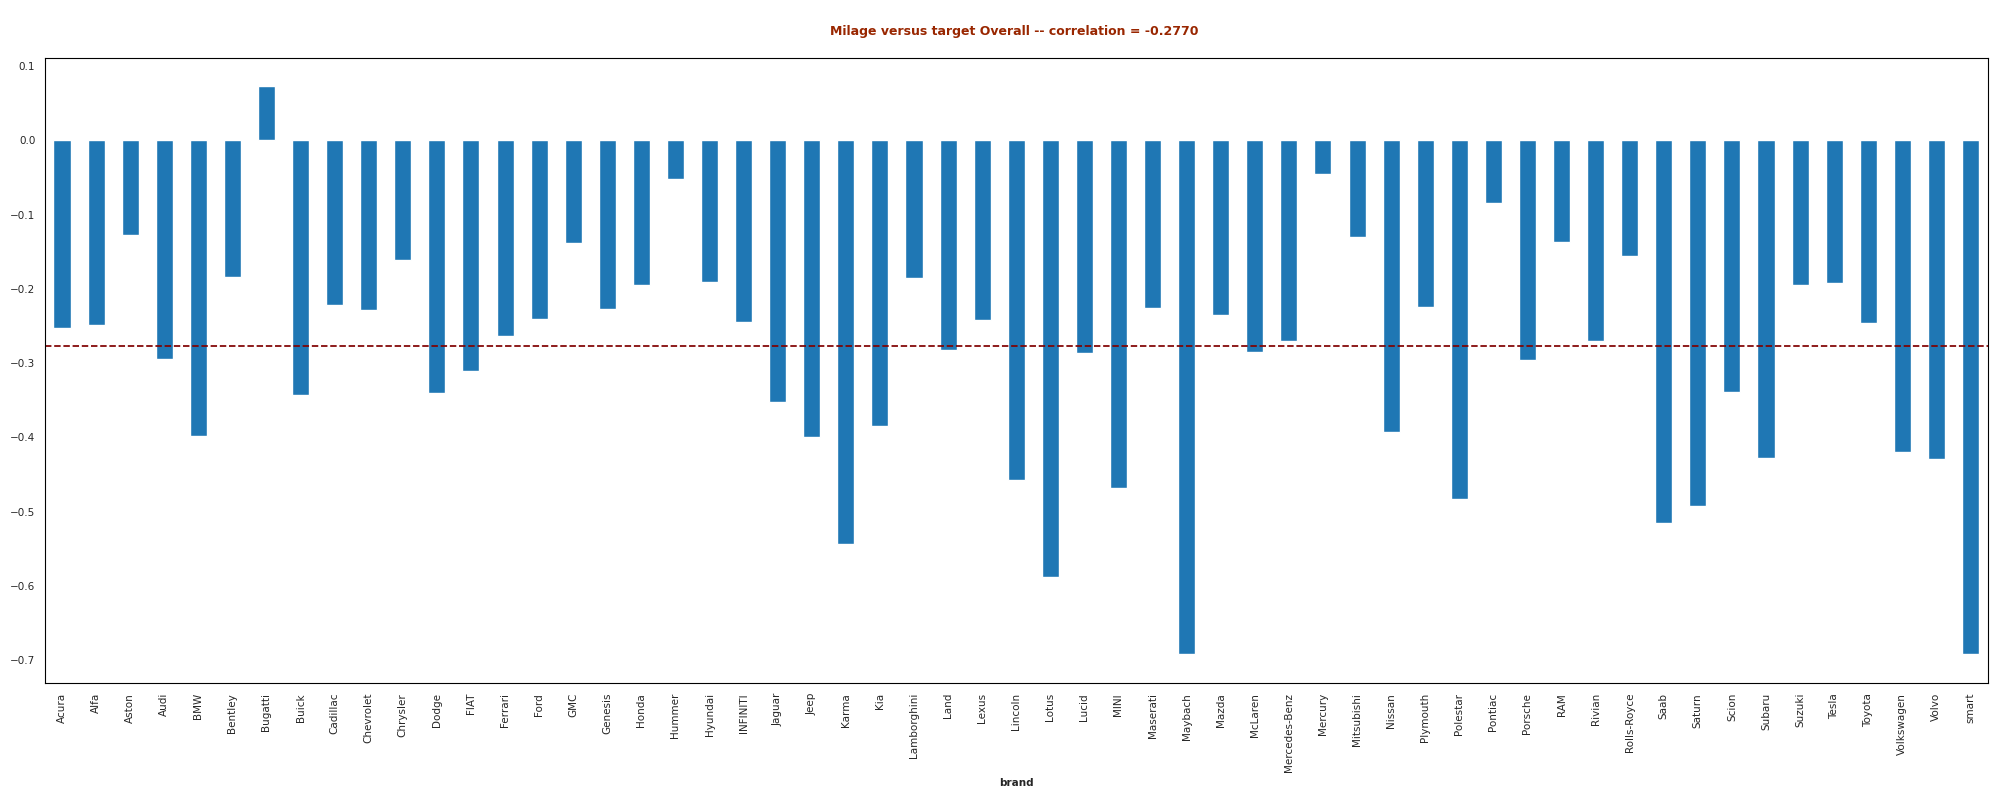

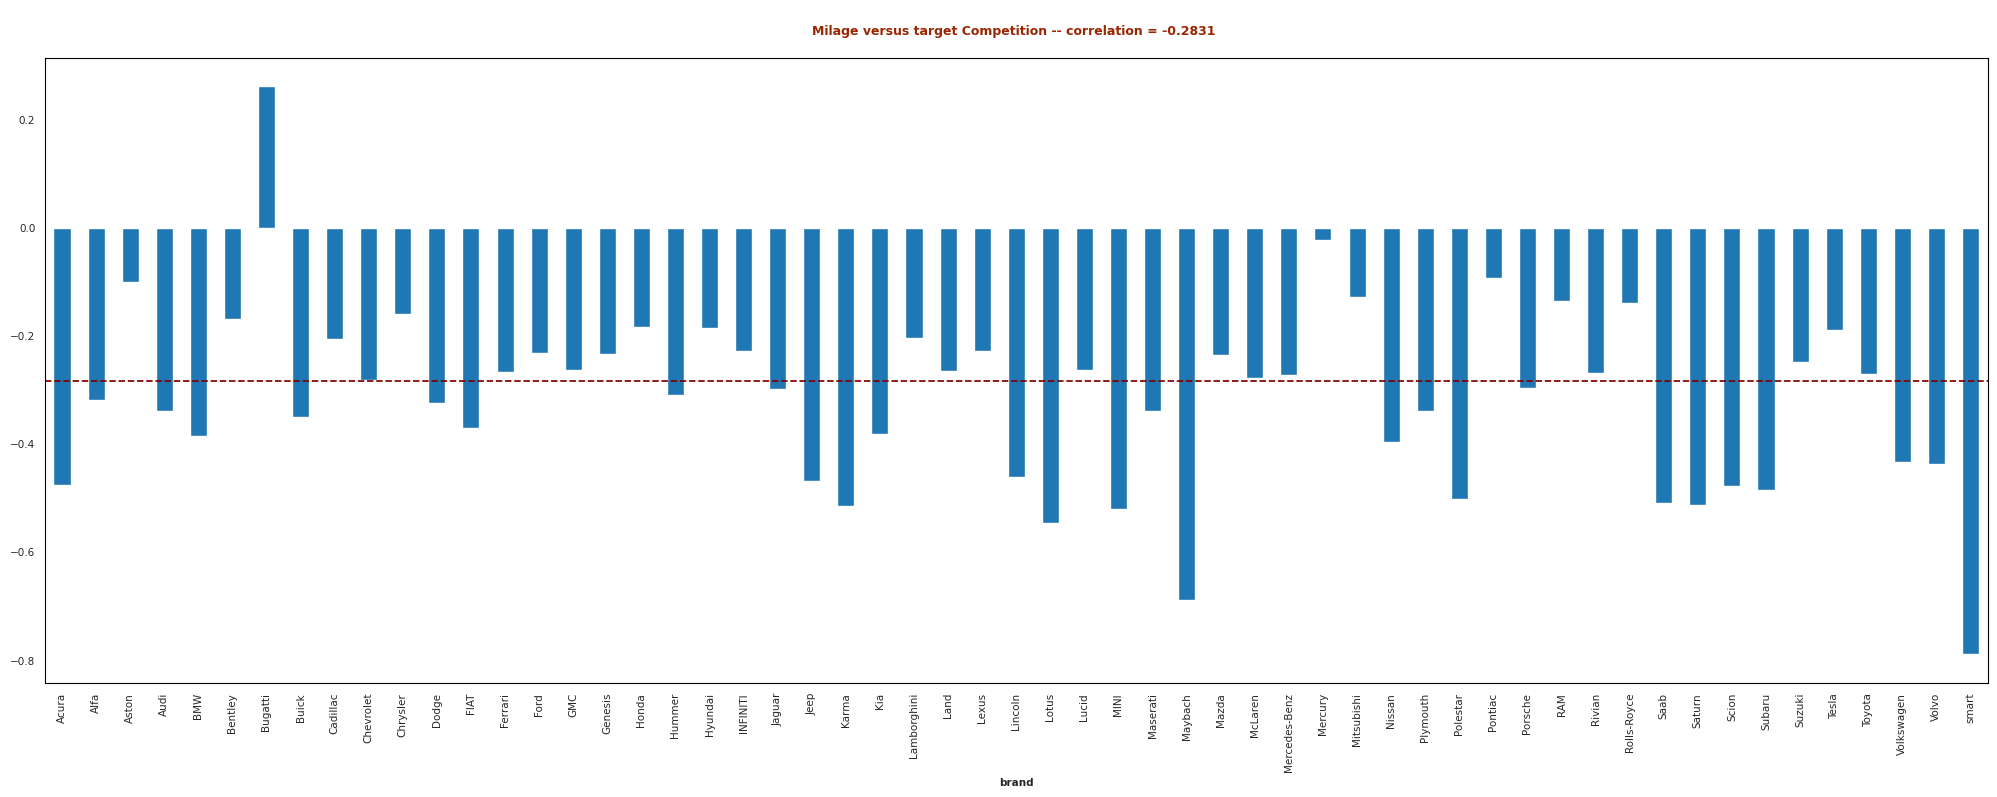

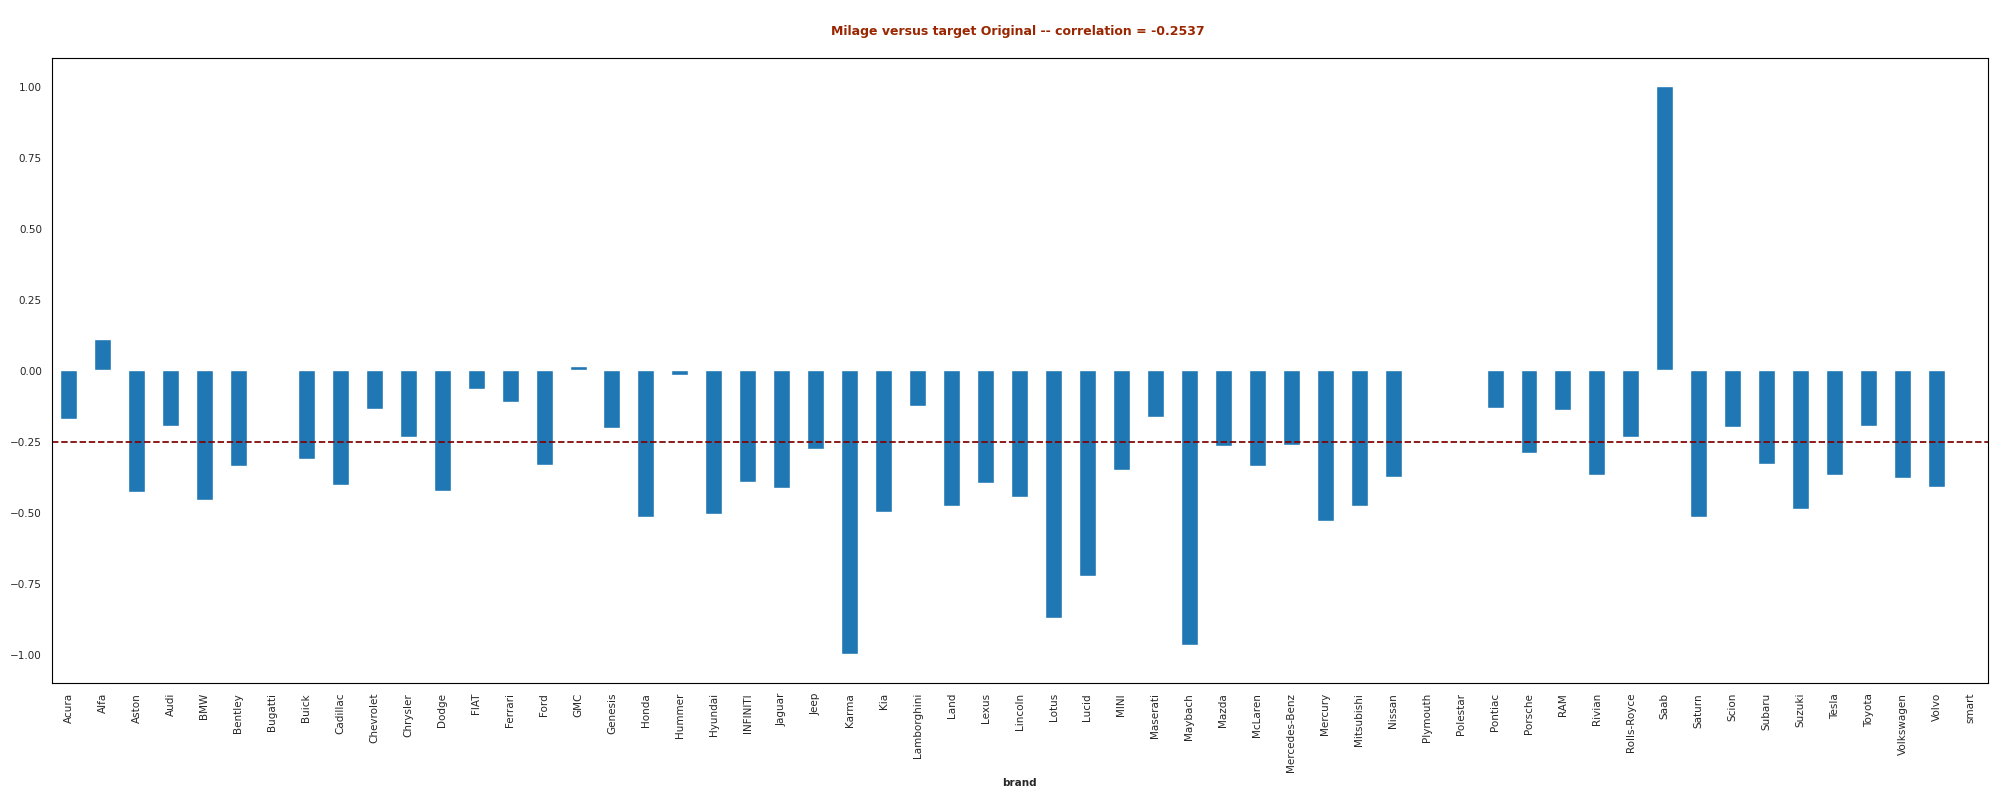


CPU times: user 5.34 s, sys: 1.33 s, total: 6.67 s
Wall time: 4.57 s


In [17]:
%%time 

if CFG.ftre_plots_req == "Y":
    AnalyzeMilage(pp.train, "Overall")
    print("\n\n")
    AnalyzeMilage(pp.train.loc[pp.train.Source == "Competition"], "Competition")
    print("\n\n")
    try:
        AnalyzeMilage(pp.train.loc[pp.train.Source == "Original"], "Original")
    except:
        pass

collect();
print();

## **INFERENCES**

The above plot is quite intuitive as it indicates a differential sensitivity between brand pricing and milage <br>
Aspirational and luxury brands are less sensitive to milage compared to lower priced options like Smart and Nissan <br>
Milage is often negatively correlated to the price- lower milage often begets higher resale value <br>

# **DATA TRANSFORMS**

In this section, we collate a lot of public discussion and kernel ideas for feature engineering in a pipeline and present the net impact with baseline models subsequently <br>
Please find the sources as below- <br>
- https://www.kaggle.com/competitions/playground-series-s4e9/discussion/531532 <br>
- https://www.kaggle.com/competitions/playground-series-s4e9/discussion/531616

In [18]:
%%time 

class FtreMaker:
    "This class makes new features using public discussions and kernel ideas"
    
    def __init__(self):
        self.fuel_type_dict = {
            'Gasoline': 0,
            'Hybrid': 1,
            'E85 Flex Fuel': 2,
            'uknown': 3,
            'Diesel': 4,
            'dash': 5,
            'Plug-In Hybrid': 6,
            'not supported': 7
        }

        self.accident_dict = {
            'None reported': 0,
            'At least 1 accident or damage reported': 1,
            'uknown': 2
        }

        self.clean_title_dict = {
            'Yes': 0,
            'uknown': 1
        }

        self.expensive_ext_color = \
        [  'Blue Caelum', 'Dark Sapphire', 'Bianco Monocerus', 'C / C', 'Ice',
           'Tempest', 'Beluga Black', 'Bianco Icarus Metallic', 
           'BLU ELEOS', 'Shadow Black', 'Nero Noctis', 'Sandstone Metallic',
           'Lizard Green', 'Balloon White', 'Onyx', 'Donington Grey Metallic',
           'China Blue', 'Diamond White', 'Rosso Corsa', 'Granite',
           'Rosso Mars Metallic', 'Carpathian Grey', 'Kemora Gray Metallic',
           'Grigio Nimbus', 'dash', 'Bianco Isis', 'Python Green', 'Fountain Blue',
           'Custom Color', 'Vega Blue', 'Designo Magno Matte',
           'Brands Hatch Gray Metallic', 'Rift Metallic', 'Gentian Blue Metallic',
           'Arancio Borealis', 'BLUE', 'Aventurine Green Metallic', 'Apex Blue',
           'Daytona Gray Pearl Effect', 'Daytona Gray Pearl Effect w/ Black Roof',
           'Matte White', 'Carpathian Grey Premium Metallic', 'Blue Metallic',
           'Santorini Black Metallic', 'Quartzite Grey Metallic',
           'Carrara White Metallic', 'BLACK', 'Kinetic Blue', 'Nero Daytona'
        ]

        self.expensive_int_color = \
        ['Dark Auburn', 'Hotspur', 'Cobalt Blue', 'Beluga Hide', 'Linen',
         'Beluga', 'Black / Brown', 'Nero Ade', 'Sahara Tan', 'Portland']

        self.expensive_hp = \
        [443.0, 473.0, 493.0, 502.0, 521.0, 542.0, 
         543.0, 571.0, 572.0, 573.0, 580.0,
         591.0, 602.0, 611.0, 616.0, 620.0, 624.0, 
         640.0, 641.0, 651.0, 710.0, 715.0, 760.0, 788.0, 797.0
        ]
        
        self.series_pattern = \
        re.compile(r'^[A-Za-z0-9\-]+')
        
        self.version_pattern = \
        re.compile(r'([0-9]+\.[0-9]+[A-Za-z]*)|([A-Z]+[0-9]*)')
        
        self.trim_pattern = \
        re.compile(r'\b(Base|Sport|Premium|Ultimate|XLT|LZ|LT|Plus|Touring|SE|LE|Limited|Platinum|Performance|S|V6|GT|EX|SX|XLE|SR|SL|SV|XSE|TRD|RS|GranSport|Signature|Quad Cab|DRW|Cabriolet|Carbon Edition|Trail Boss|Prestige|Essence|Reserve|xDrive|4MATIC|PreRunner|EcoBoost|Scat Pack|Competition|Adventure Package|Laramie|Grand Touring|Long Range)\b')
        
        self.hp_pattern = r'(\d+(\.\d+)?)HP'
        self.displacement_pattern = r'(\d+\.\d+)L'
        self.cylinder_pattern = r'(\d+) Cylinder'

        self.engine_configs = {
            'V6': 'V6', 
            'V8': 'V8', 
            'V10': 'V10', 
            'V12': 'V12',
            'Straight 6': 'Straight 6', 
            'Flat 6': 'Flat 6', 
            'I4': 'I4'
        }

        self.forced_induction = {'Turbo', 'Twin Turbo'}
        self.valve_configs    = {'DOHC', 'SOHC', 'GDI', 'PDI'}
        self.fuel_systems     = {'MPFI', 'GDI', 'PDI', 'TFSI'}
        
    def fit(self, X: pd.DataFrame, y = None, **params):
        return self
    
    def _make_mdlparts(self, model: str):
        "This method extracts model components"
        
        series  = self.series_pattern.search(model)
        version = self.version_pattern.search(model)
        trim    = self.trim_pattern.search(model)

        return {
            'Series'  : series.group(0) if series else "uknown",
            'Version' : version.group(0) if version else "uknown",
            'Trim'    : trim.group(0) if trim else "uknown"
        }
    
    def _parse_engine(self, engine_desc):
        "This metod processes the engine description feature and returns sub-parts"
        
        int_default_na = -1
        obj_default_na = "uknown"
        
        features = {
            'horsepower': int_default_na, 
            'displacement': int_default_na, 
            'cylinder_count': int_default_na,
            'engine_configuration':obj_default_na, 
            'forced_induction': obj_default_na,
            'valve_configuration': obj_default_na, 
            'fuel_system': obj_default_na, 
            'mild_hybrid': False,
        }
        
        patterns = {
            'horsepower'    : (self.hp_pattern, lambda x: float(x)),
            'displacement'  : (self.displacement_pattern, lambda x: float(x)),
            'cylinder_count': (self.cylinder_pattern, lambda x: int(x)),
        }
        
        for feature, (pattern, convert) in patterns.items():
            match = re.search(pattern, engine_desc)
            if match:
                try:
                    features[feature] = convert(match.group(1))
                except ValueError:
                    pass  
        
        features['engine_configuration'] = \
        next((config for config, name in self.engine_configs.items() if config in engine_desc), 
             obj_default_na
            )
        
        features['forced_induction'] = \
        next((induction for induction in self.forced_induction if induction in engine_desc),
             obj_default_na
            )
        
        features['valve_configuration'] = \
        next((valve for valve in self.valve_configs if valve in engine_desc), 
             obj_default_na
            )
        
        features['fuel_system'] = \
        next((system for system in self.fuel_systems if system in engine_desc), 
             obj_default_na
            )
        
        features['mild_hybrid'] = 'Mild Electric Hybrid' in engine_desc
        
        return features
    
    def _get_gear_number(self, trans):
        match = re.search(r'(\d+)[-\s]?Speed', trans)
        return int(match.group(1)) if match else -1

    def _get_transmission_type(self, trans):
        if 'A/T' in trans or 'Automatic' in trans:
            return 'Automatic'
        elif 'M/T' in trans or 'Manual' in trans:
            return 'Manual'
        elif 'CVT' in trans:
            return 'CVT'
        elif 'DCT' in trans:
            return 'DCT'
        else:
            return 'Other'

    def _get_special_features(self, trans):
        features = []
        if 'Dual Shift Mode' in trans:
            features.append('Dual Shift Mode')
        if 'Auto-Shift' in trans:
            features.append('Auto-Shift')
        if 'Overdrive' in trans:
            features.append('Overdrive')
        if 'Electronically Controlled' in trans:
            features.append('Electronically Controlled')
        if 'Variable' in trans:
            features.append('Variable')
        return ', '.join(features) if features else "uknown"

    def _get_transmission_dsg(self, trans):
        if 'A/T' in trans:
            return 'A/T'
        elif 'M/T' in trans:
            return 'M/T'
        elif 'CVT' in trans:
            return 'CVT'
        elif 'DCT' in trans:
            return 'DCT'
        else:
            return "uknown"

    def transform(self, X: pd.DataFrame, y = None, **params):
        "This method makes new features from the existing dataset"

        df = X.copy()
        print(f"\n\n---> Starting shape = {df.shape}")
        
        print(f"---> Imputing category columns")
        cat_ftre     = df.select_dtypes("object").columns
        df[cat_ftre] = df[cat_ftre].fillna("uknown")
        
        print(f"---> Performing -150 feature transforms")
        df['fuel_type_encoded']   = df['fuel_type'].map(self.fuel_type_dict)
        df['accident_encoded']    = df['accident'].map(self.accident_dict)
        df['clean_title_encoded'] = df['clean_title'].map(self.clean_title_dict)
        
        df['expensive_color_ext_encoded'] = \
        df.ext_col.isin(self.expensive_ext_color).astype(int)
        
        df['expensive_color_int_encoded'] = \
        df.int_col.isin(self.expensive_int_color).astype(int)
        
        df['expensive_hp'] = \
        df['engine'].str.extract(r'(\d+\.?\d*)HP').\
        astype(float).isin(self.expensive_hp).\
        astype(int)
        
        df['cylinder'] = \
        df['engine'].str.extract(r'(\d+\.?\d*) Cylinder').astype(float) 
        
        df['got_V'] = df['model'].str.extract(r'(\d+\.?\d*) V').notna().astype(int)
        
        print(f"---> Making car model components")
        mdlparts = df['model'].apply(self._make_mdlparts).apply(pd.Series)
        df       = pd.concat([df, mdlparts], axis=1)
        del mdlparts
        
        print(f"---> Making engine components")
        unique_engines  = df['engine'].unique()
        engine_features = [self._parse_engine(engine) for engine in unique_engines]
        engine_features = pd.DataFrame(engine_features, index = unique_engines).reset_index()
        engine_features.rename(columns={'index': 'engine'}, inplace=True)
        
        df = df.merge(engine_features, how = "left", on = "engine")
        del engine_features,unique_engines
 
        print(f"---> Making transmission components")
        df['nb_gears']   = \
        df['transmission'].apply(self._get_gear_number)
        df['transmission_mode'] = \
        df['transmission'].apply(self._get_transmission_type)
        df['transmission_special']  = \
        df['transmission'].apply(self._get_special_features)
        df['transmission_dsg'] = \
        df['transmission'].apply(self._get_transmission_dsg)
        
        print(f"---> Imputing all numeric and categorical features at the end")
        num_ftre = df.select_dtypes(include=[np.number]).columns
        cat_ftre = df.select_dtypes(include=['object']).columns
        
        df[num_ftre] = df[num_ftre].fillna(-1)
        df[cat_ftre] = df[cat_ftre].fillna("uknown").astype("category")
        
        df["Source"] = df["Source"].astype(str)
  
        print(f"\n---> Final shape = {df.shape}")
        return df

CPU times: user 42 µs, sys: 0 ns, total: 42 µs
Wall time: 47 µs


In [19]:
%%time 

xform = \
Pipeline(steps = [("MakeFtre", FtreMaker())],verbose = True)

Xtrain = pp.train.drop(CFG.target, axis=1)
ytrain = pp.train[CFG.target]
Xtest  = pp.test.copy()

PrintColor(f"---> Data transforms - train")
Xtrain = xform.fit_transform(Xtrain, ytrain)
PrintColor(f"\n\n---> Data transforms - test")
Xtest  = xform.transform(Xtest)

# Saving the train-test data for later usage:-
pd.concat([Xtrain, ytrain], axis=1).to_parquet("XYtrain.parquet")
Xtest.to_parquet("Xtest.parquet")

print();
collect()

---> Data transforms - train


---> Starting shape = (246815, 12)
---> Imputing category columns
---> Performing -150 feature transforms
---> Making car model components
---> Making engine components
---> Making transmission components
---> Imputing all numeric and categorical features at the end

---> Final shape = (246815, 35)
[Pipeline] .......... (step 1 of 1) Processing MakeFtre, total= 1.2min


---> Data transforms - test


---> Starting shape = (125690, 12)
---> Imputing category columns
---> Performing -150 feature transforms
---> Making car model components
---> Making engine components
---> Making transmission components
---> Imputing all numeric and categorical features at the end

---> Final shape = (125690, 35)

CPU times: user 1min 50s, sys: 1.74 s, total: 1min 52s
Wall time: 1min 52s


45

In [20]:
%%time 

if CFG.test_req == "Y":
    Xtrain = Xtrain.sample(frac = CFG.test_sample_frac)
    ytrain = ytrain.loc[Xtrain.index]
    Xtrain.index = range(len(Xtrain))
    ytrain.index = range(len(Xtrain))
    
    PrintColor(f"---> Syntax check is needed - shapes = {Xtrain.shape} | {ytrain.shape}")
    
else:
    PrintColor(f"---> Syntax check is not needed")

---> Syntax check is not needed
CPU times: user 87 µs, sys: 4 µs, total: 91 µs
Wall time: 96.1 µs


# **MODEL TRAINING**

In [21]:
%%time 

class OptunaEnsembler:
    """
    This is the Optuna ensemble class-
    Source- https://www.kaggle.com/code/arunklenin/ps3e26-cirrhosis-survial-prediction-multiclass
    """;
    
    def __init__(self):
        self.study        = None
        self.weights      = None
        self.random_state = CFG.state
        self.n_trials     = CFG.ntrials
        self.direction    = CFG.metric_obj
        
    def ScoreMetric(self, ytrue, ypred):
        """
        This is the metric function for the competition
        """;
        return mse(ytrue, ypred, squared = False)

    def _objective(self, trial, y_true, y_preds):
        """
        This method defines the objective function for the ensemble
        """;
        
        if isinstance(y_preds, pd.DataFrame) or isinstance(y_preds, np.ndarray):
            weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(y_preds.shape[-1])]
            axis = 1
            
        elif isinstance(y_preds, list):
            weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(len(y_preds))]
            axis = 0

        # Calculating the weighted prediction:-
        weighted_pred  = np.average(np.array(y_preds), axis = axis, weights = weights)
        score          = self.ScoreMetric(y_true, weighted_pred)
        return score

    def fit(self, y_true, y_preds):
        "This method fits the Optuna objective on the fold level data";
        
        optuna.logging.set_verbosity = optuna.logging.ERROR;
        self.study = \
        optuna.create_study(sampler    = TPESampler(seed = self.random_state), 
                            pruner     = HyperbandPruner(),
                            study_name = "Ensemble", 
                            direction  = self.direction,
                           );
        
        obj = partial(self._objective, y_true = y_true, y_preds = y_preds);
        self.study.optimize(obj, n_trials = self.n_trials);
               
        if isinstance(y_preds, list):
            self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))]
            
        else:
            self.weights = [self.study.best_params[f"weight{n}"] for n in range(y_preds.shape[-1])]

    def predict(self, y_preds):
        "This method predicts using the fitted Optuna objective";
        
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict';
        
        if isinstance(y_preds, list):
            weighted_pred = np.average(np.array(y_preds), axis=0, weights = self.weights)
            
        else:
            weighted_pred = np.average(np.array(y_preds), axis=1, weights = self.weights)
            
        return weighted_pred

    def fit_predict(self, y_true, y_preds):
        """
        This method fits the Optuna objective on the fold data, then predicts the test set
        """;
        self.fit(y_true, y_preds)
        return self.predict(y_preds)
    
    def weights(self):
        return self.weights
    
print();
collect();


CPU times: user 142 ms, sys: 49 µs, total: 142 ms
Wall time: 141 ms


In [22]:
%%time

class MdlDeveloper(CFG):
    """
    This class implements the training pipeline elements-
    1. Initializes the Model predictions
    2. Trains and infers models
    3. Returns the OOF and model test set predictions
    """;
    
    def __init__(
        self, Xtrain, ytrain, ygrp, Xtest, 
        sel_cols, cat_cols, enc_cols, 
        **kwarg
    ):
        """
        In this method, we initialize the below-
        1. Train-test data, selected columns
        2. Metric, custom scorer, model and cv object
        3. Output tables for score and predictions
        """;
        
        self.Xtrain      = Xtrain
        self.ytrain      = ytrain
        self.y_grp       = ygrp
        self.Xtest       = Xtest
        self.sel_cols    = sel_cols
        self.cat_cols    = cat_cols
        self.enc_cols    = enc_cols
     
        self._DefineModels();
        self.cv          = self.all_cv[self.mdlcv_mthd]
        self.methods     = list(self.Mdl_Master.keys())
        self.OOF_Preds   = pd.DataFrame()
        self.Mdl_Preds   = pd.DataFrame()
        
        self.Scores      = pd.DataFrame(columns = self.methods + ["Ensemble"], 
                                        index = range(self.n_splits * self.n_repeats)
                                       )
        self.TrainScores = pd.DataFrame(columns = self.methods, 
                                        index = range(self.n_splits * self.n_repeats)
                                       )
        
        self.mdlscorer   = make_scorer(self.ScoreMetric, 
                                       greater_is_better = False,
                                       needs_proba       = False,
                                       needs_threshold   = False,
                                      )
        
        PrintColor(f"\n---> Selected model options-")
        try:
            with np.printoptions(linewidth = 150):
                pprint(np.array(self.methods), depth = 1, width = 100, indent = 5)
        except:
            pprint(self.methods, depth = 1, width = 100, indent = 5)
              
    def _DefineModels(self):
        """
        This method initiliazes models for the analysis
        It also initializes the CV methods and class-weights that could be tuned going ahead.
        """;
        
        # Commonly used CV strategies for later usage:-
        self.all_cv = \
        {'KF'  : KFold(n_splits = self.n_splits, shuffle = True, random_state= self.state),
         'RKF' : RKF(n_splits   = self.n_splits, n_repeats = self.n_repeats, random_state= self.state),
         'RSKF': RSKF(n_splits  = self.n_splits, n_repeats = self.n_repeats, random_state= self.state),
         'SKF' : SKF(n_splits   = self.n_splits, shuffle = True, random_state= self.state),
         'SGKF': SGKF(n_splits  = self.n_splits, shuffle= True, random_state= self.state),
        }
           
        self.Mdl_Master = \
        {                      
         'XGB1R': XGBR(**{'tree_method'           : "hist",
                          "device"                : "cuda" if self.gpu_switch == "ON" else "cpu", 
                          'objective'             : "reg:squarederror",
                          'eval_metric'           : "rmse",
                          'random_state'          : self.state,
                          'colsample_bytree'      : 0.45,
                          'learning_rate'         : 0.025,
                          'max_depth'             : 7,
                          'n_estimators'          : 3000,                         
                          'reg_alpha'             : 0.001,
                          'reg_lambda'            : 0.001,
                          'min_child_weight'      : 18,
                          'early_stopping_rounds' : self.nbrnd_erly_stp,
                          'verbosity'             : 0,
                          'enable_categorical'    : True, 
                         }
                      ),
                       
         'LGBM1R':LGBMR(**{'device'              : "gpu" if self.gpu_switch == "ON" else "cpu",
                           'objective'           : 'regression_l2',
                           'boosting_type'       : 'gbdt',
                           'metric'              : "rmse",
                           'random_state'        : self.state,
                           'colsample_bytree'    : 0.45,
                           'subsample'           : 0.85,
                           'learning_rate'       : 0.025,
                           'max_depth'           : 7,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 25,
                           'reg_alpha'           : 0.01,
                           'reg_lambda'          : 0.001,
                           'verbosity'           : -1, 
                           'categorical_feature' : [f"name: {c}" for c in self.cat_cols],
                          }
                       ),
            
         'LGBM2R':LGBMR(**{'device'              : "gpu" if self.gpu_switch == "ON" else "cpu",
                           'objective'           : 'regression_l2',
                           'boosting_type'       : 'gbdt',
                           'data_sample_strategy': "goss",
                           'metric'              : "rmse",
                           'random_state'        : self.state,
                           'colsample_bytree'    : 0.67,
                           'subsample'           : 0.85,
                           'learning_rate'       : 0.025,
                           'max_depth'           : 7,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 22, 
                           'reg_alpha'           : 0.001,
                           'reg_lambda'          : 0.01,
                           'verbosity'           : -1, 
                           'categorical_feature' : [f"name: {c}" for c in self.cat_cols],
                          }
                       ),
              
        "CB1R" :  CBR(**{'task_type'           : "GPU" if self.gpu_switch == "ON" else "CPU",
                         'loss_function'       : 'RMSE',
                         'eval_metric'         : "RMSE",
                         'bagging_temperature' : 0.25,
                         'colsample_bylevel'   : 0.70,
                         'iterations'          : 3000,
                         'learning_rate'       : 0.04,
                         'max_depth'           : 6,
                         'l2_leaf_reg'         : 0.25,
                         'min_data_in_leaf'    : 12,
                         'random_strength'     : 0.25, 
                         'verbose'             : 0,
                         'use_best_model'      : True,
                         'cat_features'        : self.cat_cols,
                        }
                     ),    
        };
        return self
    
    def ScoreMetric(self, ytrue, ypred):
        """
        This is the metric function for the competition scoring
        """;
        return mse(ytrue, ypred, squared = False)
    
    def ClbMetric(self, ytrue, ypred):
        """
        This is the calibration metric
        """;
        return brier_score_loss(ytrue, ypred)
        
    def PostProcessPred(self, ypred):
        """
        This is an optional post-processing method
        We clip the values of the target between 0 and log of maximum train target values
        """;
        return ypred
        
    def TrainMdl(
        self, target: str, test_preds_req: str = "Y", save_models = "N"
    ):
        """
        This method trains and infers from the model suite and returns the predictions and scores
        It optionally predicts the test set too, if desired by the user
        """;

        # Initializing I-O:- 
        X,y, Xt    = \
        self.Xtrain[self.sel_cols], self.ytrain.copy(deep = True), self.Xtest[self.sel_cols]
        cols_drop  = ["Source", "id",]
        ens        = OptunaEnsembler()
        
        self.FtreImp = \
        pd.DataFrame(columns = self.methods, 
                     index   = [c for c in self.sel_cols if c not in cols_drop]
                    ).fillna(0)
        
        # Making CV folds:-        
        for fold_nb, (train_idx, dev_idx) in tqdm(enumerate(self.cv.split(X, self.y_grp))):
            Xtr  = X.iloc[train_idx].drop(columns = cols_drop, errors = 'ignore')
            Xdev = X.iloc[dev_idx].drop(columns = cols_drop, errors = 'ignore')   
            ytr  = y.loc[y.index.isin(Xtr.index)]
            ydev = y.loc[y.index.isin(Xdev.index)]
                     
            # Initializing the OOF and test set predictions:-            
            oof_preds = pd.DataFrame(columns = self.methods, index = Xdev.index)
            mdl_preds = pd.DataFrame(columns = self.methods, index = Xt.index)
            
            PrintColor(f"\n{'=' * 5} FOLD {fold_nb + 1} {'=' * 5}\n")
            # Initializing models across methods:-
            for method in tqdm(self.methods):
                model = Pipeline(steps = [("M", self.Mdl_Master.get(method))]) 

                # Fitting the model:-          
                if "CB" in method:    
                    model.fit(Xtr, ytr, 
                              M__eval_set = [(Xdev, ydev)], 
                              M__verbose = 0,
                              M__early_stopping_rounds = self.nbrnd_erly_stp,
                             )

                elif "LGBM" in method:
                    model.fit(Xtr, ytr, 
                              M__eval_set = [(Xdev, ydev)], 
                              M__callbacks = [log_evaluation(0), 
                                              early_stopping(
                                                  stopping_rounds = self.nbrnd_erly_stp, 
                                                  verbose = False,
                                              ),
                                             ],
                             ) 

                elif "XGB" in method:
                     model.fit(Xtr, ytr, 
                               M__eval_set = [(Xdev, ydev)], 
                               M__verbose  = 0,
                              )           

                else:
                    model.fit(Xtr, ytr);
               
                # Collating feature importance:-
                try: 
                    self.FtreImp[method] += model["M"].feature_importances_
                except: 
                    pass;
                    
                # Collecting predictions and scores and post-processing OOF based on model method:-
                dev_preds    = self.PostProcessPred(model.predict(Xdev))
                train_preds  = self.PostProcessPred(model.predict(Xtr))
                tr_score     = self.ScoreMetric(ytr.values.flatten(),train_preds)
                score        = self.ScoreMetric(ydev.values.flatten(),dev_preds)
                         
                PrintColor(f"OOF = {score:.5f} | Train = {tr_score:.5f} | {method}",
                           color = Fore.CYAN
                          )
                oof_preds[method] = dev_preds

                # Integrating the predictions and scores:-               
                self.Scores.at[fold_nb, method]      = np.round(score, decimals= 6)
                self.TrainScores.at[fold_nb, method] = np.round(tr_score, decimals= 6)
            
                if test_preds_req == "Y": 
                    mdl_preds[method] = \
                    self.PostProcessPred(model.predict(
                        Xt.drop(columns = cols_drop, errors = "ignore")
                    )
                    )
                
            try:
                del dev_preds, train_preds, tr_score, score
            except:
                pass
                
            # Ensembling the predictions with post-processing:-
            oof_preds["Ensemble"]  = self.PostProcessPred(ens.fit_predict(ydev, oof_preds[self.methods]))
            score                  = self.ScoreMetric(ydev, oof_preds["Ensemble"].values)
            self.OOF_Preds         = pd.concat([self.OOF_Preds, oof_preds], axis = 0, ignore_index = False)
            self.Scores.at[fold_nb, "Ensemble"] = np.round(score,6)
            
            if test_preds_req == "Y": 
                mdl_preds["Ensemble"] = ens.predict(mdl_preds[self.methods])
                self.Mdl_Preds        = pd.concat([self.Mdl_Preds, mdl_preds], 
                                                  axis = 0, 
                                                  ignore_index = False
                                                 )
                
        # Averaging the predictions after all folds:-       
        self.OOF_Preds = self.OOF_Preds.groupby(level = 0).mean()
        
        if test_preds_req == "Y": 
            self.Mdl_Preds = \
            self.Mdl_Preds[self.methods + ["Ensemble"]].\
            groupby(level=0).\
            mean()
            
        return (self.OOF_Preds, self.Mdl_Preds, self.Scores, self.TrainScores)
       
    def MakeMLPlots(self):
        """
        This method makes plots for the ML models, including feature importance
        """
        
        fig, axes = plt.subplots(len(self.methods), 1,
                                 figsize = (12, len(self.methods) * 6),
                                 gridspec_kw = {'hspace': 0.9, 'wspace': 0.2}, 
                                )
    
        for i, col in enumerate(self.methods): 
            ax = axes[i]
            self.FtreImp[col].plot.bar(ax = ax, color = '#0073e6')
            ax.set_title(f"{col} Importances", **self.title_specs)
            ax.set(xlabel = '', ylabel = '')

        plt.tight_layout()
        plt.show()
                   
print()
collect();


CPU times: user 145 ms, sys: 22 µs, total: 145 ms
Wall time: 144 ms


In [23]:
%%time 

if CFG.ML == "Y":
    sel_cols = Xtrain.columns;
    PrintColor(f"\n---> Selected model columns")
    cat_ftre = list(Xtrain.select_dtypes("category").columns)

    with np.printoptions(linewidth = 150):
        PrintColor(f"\n---> All selected columns\n");
        pprint(np.array(sel_cols));
        
        PrintColor(f"\n---> Selected category columns\n");
        pprint(np.array(cat_ftre));

print();
collect();


---> Selected model columns

---> All selected columns

array(['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'Source',
       'fuel_type_encoded', 'accident_encoded', 'clean_title_encoded', 'expensive_color_ext_encoded', 'expensive_color_int_encoded', 'expensive_hp',
       'cylinder', 'got_V', 'Series', 'Version', 'Trim', 'horsepower', 'displacement', 'cylinder_count', 'engine_configuration', 'forced_induction',
       'valve_configuration', 'fuel_system', 'mild_hybrid', 'nb_gears', 'transmission_mode', 'transmission_special', 'transmission_dsg'],
      dtype=object)

---> Selected category columns

array(['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'Series', 'Version', 'Trim',
       'engine_configuration', 'forced_induction', 'valve_configuration', 'fuel_system', 'transmission_mode', 'transmission_special',
       'transmission_dsg'], dty

In [24]:
%%time 

if CFG.ML == "Y":
    md = \
    MdlDeveloper(
        Xtrain, ytrain, ytrain, Xtest, 
        sel_cols = sel_cols, 
        cat_cols = cat_ftre, 
        enc_cols = []
    )
    
    OOF_Preds, Mdl_Preds, Scores, TrainScores = \
    md.TrainMdl(test_preds_req = "Y", target = CFG.target)      
    clear_output()
    
    utils.DisplayScores(
        Scores, TrainScores, 
        methods = list(md.Mdl_Master.keys()),
    )
    
else:
    PrintColor(f"---> ML models are not needed", color = Fore.RED)
              
print()
collect();




---> OOF score across all methods and folds



OOF scores across methods and folds
 
 
 
   
 XGB1R 
 LGBM1R 
 LGBM2R 
 CB1R 
 Ensemble 
 
 
 
 
 0 
 72672.40579 
 72757.74063 
 72705.53286 
 72532.22639 
 72441.12611 
 
 
 1 
 64750.91860 
 64639.37598 
 64638.27061 
 64571.95921 
 64445.78139 
 
 
 2 
 78424.99137 
 78460.72897 
 78404.66918 
 78471.87228 
 78274.25019 
 
 
 3 
 66351.12154 
 66312.82710 
 66354.80669 
 66208.37321 
 66109.05830 
 
 
 4 
 75475.56042 
 75514.54697 
 75516.35551 
 75253.86336 
 75218.99876 
 
 
 

 
 
Train scores across methods and folds
 
 
 
   
 XGB1R 
 LGBM1R 
 LGBM2R 
 CB1R 
 
 
 
 
 0 
 67927.99876 
 69001.85127 
 68700.14917 
 69992.63898 
 
 
 1 
 69059.55966 
 70515.17165 
 70334.30965 
 71653.85125 
 
 
 2 
 65443.49720 
 66869.22925 
 66526.60869 
 68979.53746 
 
 
 3 
 69378.24176 
 70262.41328 
 70695.74807 
 71122.71065 
 
 
 4 
 66510.58199 
 68071.81627 
 67852.62126 
 68586.58792

,XGB1R,LGBM1R,LGBM2R,CB1R,Ensemble
0,71534.99954,71537.04393,71523.92697,71407.65889,71297.84295



CPU times: user 1h 7min 12s, sys: 36.5 s, total: 1h 7min 48s
Wall time: 21min 58s


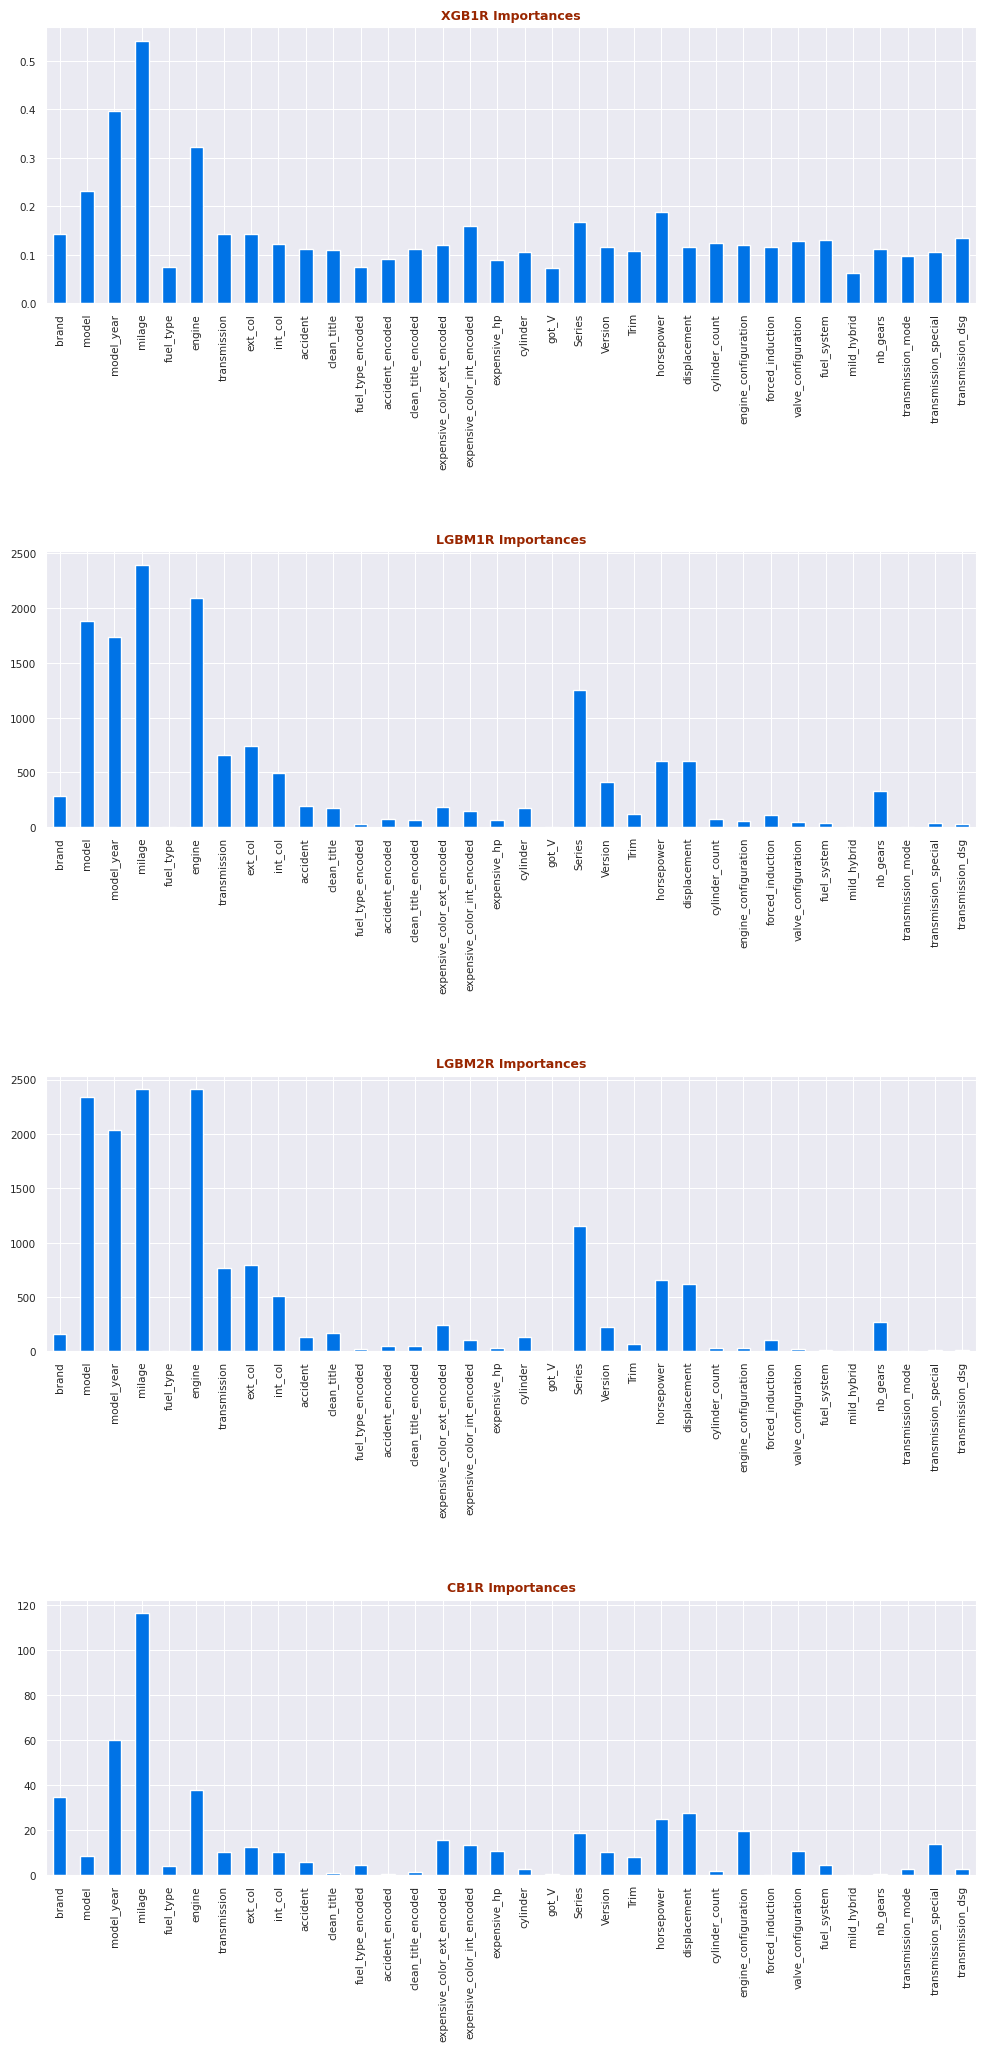

CPU times: user 2.73 s, sys: 190 ms, total: 2.92 s
Wall time: 2.67 s


In [25]:
%%time 

if CFG.ML == "Y":
    md.MakeMLPlots()

## **INFERENCES**

1. Milage is the highest important feature - this is intuitive as cars driven less are likely to fetch more resale value <br>
2. Model year (age) is also highly important, this is natural as older cars are likely to be sold for lower prices <br>
3. Transmission and engine components are worthy of keeping an eye on - features like number of cylinders, transmission type and displacement are seemingly noteworthy <br>
4. Adding NNs and some simpler non-tree models to the existing models will also be worthy of exploration. We will do this in the upcoming versions of the base-work! <br>

# **CLOSURE**

In [26]:
%%time 

OOF_Preds.to_parquet(f"OOF_Preds_V{CFG.version_nb}.parquet")
Mdl_Preds.to_parquet(f"Mdl_Preds_V{CFG.version_nb}.parquet")

pp.sub_fl[CFG.target] = Mdl_Preds["Ensemble"].values
pp.sub_fl.to_csv("submission_noblend.csv", index = False)

# Blending with good public work
all_subs = \
pd.read_csv(f"/kaggle/input/s4e9-autogluon-blend/submission.csv",
            index_col = "id"
           )
all_subs["Mysub"] = Mdl_Preds["Ensemble"].values

pp.sub_fl[CFG.target] = \
np.average(all_subs.values, 
           axis=1, 
           weights = [0.75, 0.25]
          )
pp.sub_fl.to_csv("submission_blend.csv", index = False)

print()
collect();


CPU times: user 1.27 s, sys: 120 ms, total: 1.39 s
Wall time: 1.43 s


In [27]:
!ls
print("\n\nSubmission with blend\n")
!head submission_blend.csv
print("\n\nSubmission without blend\n")
!head submission_noblend.csv

Mdl_Preds_V6.parquet  Xtest.parquet	  submission_blend.csv
OOF_Preds_V6.parquet  __notebook__.ipynb  submission_noblend.csv
XYtrain.parquet       catboost_info	  xgb_optimize.log


Submission with blend

id,price
188533,18046.278568479942
188534,78632.46719703713
188535,55170.52527952957
188536,29145.106508981396
188537,29849.48643723983
188538,17908.489323190544
188539,13435.244827496545
188540,43699.08779096012
188541,80335.5119683436


Submission without blend

id,price
188533,18848.5681821686
188534,75449.22050439304
188535,54963.25450308989
188536,27587.645863005582
188537,30450.324228296045
188538,18569.20835558055
188539,16329.61845895829
188540,44326.05776132799
188541,79015.07711617116


Dear readers, <br>
Thanks for perusing my work insofar and all the support you have given me in these years! I will be grateful to receive your support going ahead as well! <br>

Wishing you the best for the competition and happy learning! <br>

Best regards, <br>
Ravi Ramakrishnan <br>